In [1]:
import findspark
import folium
from IPython.core.display import display, HTML
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pandas.plotting import scatter_matrix
from pyspark.sql import *
from pyspark.sql.functions import *
import re
import scipy as sp
from scipy import stats
import seaborn as sns
from sklearn import metrics
from sklearn.cluster import DBSCAN
from sklearn.datasets.samples_generator import make_blobs
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

findspark.init(os.environ['SPARK_HOME'])

%matplotlib inline

spark = SparkSession.builder.getOrCreate()

In [2]:
dataframe = pd.read_csv('../data/processed/clean_food_cities_arrond_with_tax.csv')
dataframe = dataframe.drop(columns=['Unnamed: 0'])
dataframe.head()

,food_item_index,nutrition-score-fr_100g,nutrition-score-uk_100g,nutrition_grade_numeric,serving_size,energy_100g,fat_100g,saturated-fat_100g,proteins_100g,carbohydrates_100g,...,Poverty rate (tenants) (%),Share of activity revenue (%),Share of retreat pension revenue (%),Share of heritage revenue and other (%),Share of social benefits revenue (%),Share of taxes (%),City name,Department,Region,custom_arrondissement_code
0,359180,14.0,19.0,4,150 g,1243.0,24.0,17.0,19.0,1.3,...,29.609475,65.9,31.2,11.1,7.1,-15.3,Belley,01,84,01001
1,359153,15.0,20.0,4,NaN,1402.0,30.0,19.0,15.0,1.3,...,29.609475,65.9,31.2,11.1,7.1,-15.3,Belley,01,84,01001
2,359177,15.0,20.0,4,NaN,1435.0,31.0,21.0,15.0,1.0,...,29.609475,65.9,31.2,11.1,7.1,-15.3,Belley,01,84,01001
3,359157,14.0,19.0,4,NaN,1238.0,24.0,18.0,19.0,1.0,...,29.609475,65.9,31.2,11.1,7.1,-15.3,Belley,01,84,01001
4,359155,15.0,20.0,4,NaN,1435.0,31.0,21.0,15.0,1.0,...,29.609475,65.9,31.2,11.1,7.1,-15.3,Belley,01,84,01001


# 1. Distribution of the products per nutrition grade

* Nutrition grade has integer values between 1 and 5, 1 indicating healthy food items and 5 describing unhealthy items.

* Nutrition score (UK or Fr.) has values between -15 and 40. -15 indicates a healthy food item, 40 indicates an unhealthy food item. 

The correspondence between the two of them for solid foods is:

* Nutrition grade = 1 : nutrition score $\in [-15, : -1]$
* Nutrition grade = 2 : nutrition score $\in [0, 2]$
* Nutrition grade = 3 : nutrition score $\in [3, 10]$
* Nutrition grade = 4 : nutrition score $\in [11, 18]$
* Nutrition grade = 5 : nutrition score $\in [19, 40]$

The correspondence between the two of them for beverages is:

* Nutrition grade = 1 : Water
* Nutrition grade = 2 : nutrition score $\in [-15, 1]$
* Nutrition grade = 3 : nutrition score $\in [2, 5]$
* Nutrition grade = 4 : nutrition score $\in [6, 9]$
* Nutrition grade = 5 : nutrition score $\in [10, 40]$

https://fr.openfoodfacts.org/nutriscore

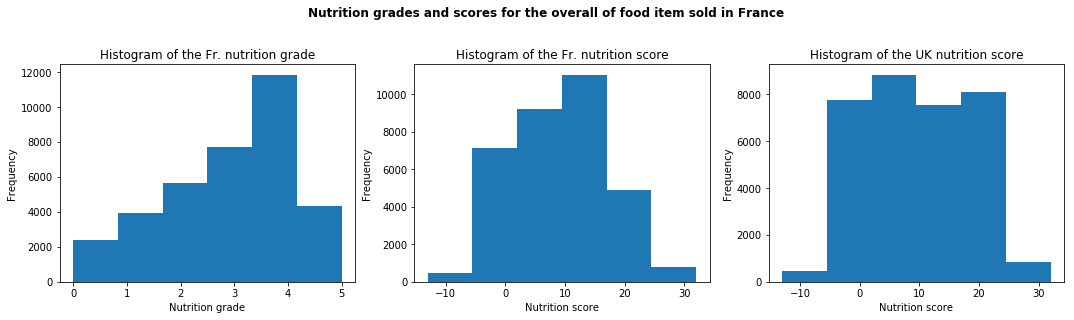

In [6]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 4))
f.suptitle("Nutrition grades and scores for the overall of food item sold in France", 
           y=1.08, fontweight="bold")
dataframe['nutrition_grade_numeric'].plot.hist(bins=6, ax=ax1)
ax1.set_title("Histogram of the Fr. nutrition grade")
ax1.set_ylabel("Frequency")
ax1.set_xlabel("Nutrition grade")

dataframe['nutrition-score-fr_100g'].plot.hist(bins=6, ax=ax2)
ax2.set_title("Histogram of the Fr. nutrition score")
ax2.set_ylabel("Frequency")
ax2.set_xlabel("Nutrition score")

dataframe['nutrition-score-uk_100g'].plot.hist(bins=6, ax=ax3)
ax3.set_title("Histogram of the UK nutrition score")
ax3.set_ylabel("Frequency")
ax3.set_xlabel("Nutrition score")
plt.show()

When we look at the nutrition grade histogram, we see that most of the products are labeled with a `3` or below, which indicates that healthy products are rare in comparison. 

When looking at the nutrition score histograms, the lack of healthy products is reinforced, however there are also a lot less **very** unhealthy products.

Since these 3 columns in our dataframe describe the same thing, we need to choose one. Intuitively, we would choose Nutrition grade because it already gives us a judgement on the quality of the food independently on if the item is solid food or beverage. 

We will however introduce two more nutrition metrics, and after that we will compute PCA on our dataframe to select only the relevant columns (i.e. columns that don't have the **exact same information**, columns that are not **redundant**). 

Reminder: `0` is equivalent to no data.

# 2. Implementation of custom nutrition scores

We introduce two more nutrition scores: calory density (the calories per serving size) and calory deviation.

Calory deviation is computed according to the nutritional standards that the calories that we consume in a day should be composed of $21 \%$ from protein, $53 \%$ from carbohydrates and $26 \%$ from fat. We then compute a deviation from this standard for each product. 

* In the first case (calory density), the metric describes how largely a product is packed with calories. Since obesity is linked with the density in calories of the ingested food items, this metric might be useful.

* In the second case (calory deviation), we aim at observing whether the products follow a healthy calory distribution. This metric would show us if a certain region has bad nutrition habits with respect to the ratios of nutriments they should eat. 

In [7]:
# we consider only the energy per 100g and the serving size
cals = dataframe[['energy_100g','serving_size']]
# we drop nan values, and serving sizes that are not relevant
cals = cals.dropna()
cals = cals.drop(cals[cals['serving_size'].str.contains("mg")].index)
cals = cals.drop(cals[cals['serving_size'].str.contains('oeuf')].index)
cals = cals.drop(cals[cals['serving_size'].str.contains('Deux tranches g')].index)
# we keep only the number of units of the usual measure unit for the product
cal = cals['serving_size'].str.replace('.*?(?P<number>[0-9.,]+)\s*(G|g|f|ml|mL).*', '\\g<number>')
cal = cal.str.replace('.*?(?P<number>[0-9.,]+)\s*(cl|cL).*', '\\g<number>0')
cal = cal.str.replace('.*?(?P<number>[0-9.,]+)\s*(Kg|L|l).*', '\\g<number>000')
# we remove values that are composed only of letters
cal = cal.str.replace('[^0-9]+', '')
cal = cal.replace('', np.nan)
cal = cal.dropna()
# we cast everything to float
cal = cal.str.replace(",", ".").astype('float')
cals.serving_size = cal
# and reinsert it in our dataframe
dataframe.loc[:,'serving_size'] = cal

cal_density = cals.serving_size * cals.energy_100g / 100

**Note**

Proteins --> 21% of cals, 4 cals/g

Carbohydrates --> 53% of cals, 4 cals/g

Fat --> 26% of cals, 9 cals/g

In [14]:
# energy has to be divided by 4.184 to convert from Joules to kilocalories
energy_in_kcal_100g = dataframe.energy_100g / 4.184
cal_deviation = ((dataframe.fat_100g * 9 / energy_in_kcal_100g - 0.26) + 
                (dataframe.carbohydrates_100g * 4 / energy_in_kcal_100g - 0.53) +
                (dataframe.proteins_100g * 4 / energy_in_kcal_100g - 0.21))/3
# we remove unknown and infinite values
cal_deviation.replace(np.infty, np.nan, inplace=True)
cal_deviation.dropna(inplace=True)
cal_deviation.describe()

count    35169.000000
mean         0.020618
std          1.550737
min         -0.333333
25%         -0.008037
50%         -0.002448
75%          0.000834
max        139.133333
dtype: float64

In [10]:
# we insert our columns in our dataframe
dataframe.loc[:,'cal_density'] = cal_density
dataframe.loc[:,'cal_deviation'] = cal_deviation

In [11]:
dataframe.head()

,food_item_index,nutrition-score-fr_100g,nutrition-score-uk_100g,nutrition_grade_numeric,serving_size,energy_100g,fat_100g,saturated-fat_100g,proteins_100g,carbohydrates_100g,...,Share of retreat pension revenue (%),Share of heritage revenue and other (%),Share of social benefits revenue (%),Share of taxes (%),City name,Department,Region,custom_arrondissement_code,cal_density,cal_deviation
0,359180,14.0,19.0,4,150.0,1243.0,24.0,17.0,19.0,1.3,...,31.2,11.1,7.1,-15.3,Belley,01,84,01001,1864.5,0.000130
1,359153,15.0,20.0,4,NaN,1402.0,30.0,19.0,15.0,1.3,...,31.2,11.1,7.1,-15.3,Belley,01,84,01001,NaN,0.000113
2,359177,15.0,20.0,4,NaN,1435.0,31.0,21.0,15.0,1.0,...,31.2,11.1,7.1,-15.3,Belley,01,84,01001,NaN,0.000026
3,359157,14.0,19.0,4,NaN,1238.0,24.0,18.0,19.0,1.0,...,31.2,11.1,7.1,-15.3,Belley,01,84,01001,NaN,0.000125
4,359155,15.0,20.0,4,NaN,1435.0,31.0,21.0,15.0,1.0,...,31.2,11.1,7.1,-15.3,Belley,01,84,01001,NaN,0.000026


# 3. Decide which columns to keep

In [14]:
numeric_cols = ['food_item_index', 'nutrition-score-fr_100g', 'nutrition-score-uk_100g',
       'nutrition_grade_numeric', 'serving_size', 'energy_100g', 'fat_100g',
       'saturated-fat_100g', 'proteins_100g', 'carbohydrates_100g',
       'sugars_100g', 'fiber_100g', 'Median revenue euros',
       'Total poverty rate (%)', 'Poverty rate (-30) (%)',
       'Poverty rate (30-39) (%)', 'Poverty rate (40-49) (%)',
       'Poverty rate (50-59) (%)', 'Poverty rate (60-74) (%)',
       'Poverty rate (75+) (%)', 'Poverty rate (house owners) (%)',
       'Poverty rate (tenants) (%)', 'Share of activity revenue (%)',
       'Share of retreat pension revenue (%)',
       'Share of heritage revenue and other (%)',
       'Share of social benefits revenue (%)', 'Share of taxes (%)',
       'cal_density', 'cal_deviation']

In [19]:
for column in numeric_cols:
    nonna = len(dataframe[dataframe[column].apply(lambda x: not np.isnan(x))]) / len(dataframe)
    print('{:<45s}{:<30s}{:<55%}'.format(column, 'Number of non-na:', nonna))

food_item_index                              Number of non-na:             100.0%                                                 
nutrition-score-fr_100g                      Number of non-na:             93.39499122489345%                                     
nutrition-score-uk_100g                      Number of non-na:             93.39499122489345%                                     
nutrition_grade_numeric                      Number of non-na:             100.0%                                                 
serving_size                                 Number of non-na:             56.53118645012118%                                     
energy_100g                                  Number of non-na:             99.18377580299189%                                     
fat_100g                                     Number of non-na:             99.48742234727136%                                     
saturated-fat_100g                           Number of non-na:             97.76304

We decided to drop all columns that have less than $40 \%$ of non-NaN values.

In [16]:
dataframe = dataframe[['food_item_index', 'nutrition-score-fr_100g', 'nutrition-score-uk_100g',
                       'nutrition_grade_numeric', 'serving_size', 'energy_100g', 'fat_100g',
                       'saturated-fat_100g', 'proteins_100g', 'carbohydrates_100g',
                       'sugars_100g', 'fiber_100g', 'cal_density', 'cal_deviation', 
                       'Median revenue euros','Total poverty rate (%)', 'Share of activity revenue (%)',
                       'Share of retreat pension revenue (%)','Share of heritage revenue and other (%)',
                       'Share of social benefits revenue (%)', 'Share of taxes (%)','City name', 'Department', 
                       'Region', 'custom_arrondissement_code']]

In our dataframe, we have now 5 types of columns:

* 1 column referring to the individual food item

* 5 columns referring to a nutrition score / grade of the food item

* 8 columns referring to the composition of the food item (sugar, fat, size...)

* 15 columns referring to the socio-economic characteristics of the city where the food item is sold

* 4 columns referring to the geographic characteristics where the item is sold


Since we can cluster all columns into 5 clear categories, we can infer that there are redundant columns in our dataframe. We wish to keep all geographic columns and the column having an ID for each food item. 

However, for our analysis we do not need 15 columns describing the socio-economic status of each city, so we wish to reduce the dimensionality of this category.

Likewise, we need to find only **one nutrition grade / score** that is relevant and hopefully **eliminate the 8 columns that refer to the food composition** (since their information is probably useless once we have an accurate nutrition grading system). 

In order to check if this dimensionality reduction can be performed, we use PCA.

In [65]:
pca_eco = PCA(n_components=0.8)
pca_eco.fit(normalized_economic_df)

print('Number of eigenvectors that explain 80% of the variance:', len(pca_eco.explained_variance_ratio_))
print(pca_eco.explained_variance_ratio_ )

Number of eigenvectors that explain 80% of the variance: 2
[ 0.51769098  0.30053247]


<Figure size 720x504 with 0 Axes>

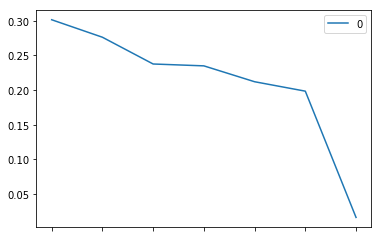

In [67]:
pca_eco_df = pd.DataFrame(pca_eco.components_, columns=normalized_economic_df.columns)
ex_var_eco_df = (pd.DataFrame(pca_eco.explained_variance_ratio_)).transpose()
feat_score_eco = ex_var_eco_df.dot(pca_eco_df).abs()

plt.figure(figsize=(10,7))
feat_score_eco.transpose().sort_values(by=0, ascending=False).plot()
plt.show()

In [68]:
feat_score_eco.transpose().sort_values(by=0, ascending=False)

,0
Share of activity revenue (%),0.305762
Median revenue euros,0.271348
Share of retreat pension revenue (%),0.243321
Total poverty rate (%),0.213983
Share of taxes (%),0.210456
Share of social benefits revenue (%),0.201085
Share of heritage revenue and other (%),0.038513


In [69]:
pd.set_option('display.max_columns', 50)
nutrition_df = dataframe[['nutrition-score-fr_100g', 'nutrition-score-uk_100g',
       'nutrition_grade_numeric', 'cal_density', 'cal_deviation', 'serving_size', 'energy_100g', 'fat_100g',
       'saturated-fat_100g', 'proteins_100g', 'carbohydrates_100g',
       'sugars_100g', 'fiber_100g']].dropna()
_, _, norm_nutri_df = normalize(nutrition_df)

pca_nutri = PCA(n_components=0.8)
pca_nutri.fit(norm_nutri_df)

print('Number of eigenvectors that explain 80% of the variance:', len(pca_nutri.explained_variance_ratio_))
print(pca_nutri.explained_variance_ratio_ )

Number of eigenvectors that explain 80% of the variance: 5
[ 0.36003387  0.17711615  0.13517729  0.10432558  0.0757208 ]


In [121]:
pd.DataFrame(pca_nutri.components_, columns=norm_nutri_df.columns)

,nutrition-score-fr_100g,nutrition-score-uk_100g,nutrition_grade_numeric,cal_density,cal_deviation,serving_size,energy_100g,fat_100g,saturated-fat_100g,proteins_100g,carbohydrates_100g,sugars_100g,fiber_100g
0,0.428311,0.434055,0.398514,0.031514,0.012804,-0.045233,0.352415,0.348999,0.337565,0.121550,0.179787,0.221140,0.100904
1,-0.096275,-0.121748,-0.097813,-0.054414,-0.079673,-0.103090,0.264298,-0.231976,-0.294012,-0.172423,0.561607,0.408970,0.473189
2,0.028995,0.005600,0.024070,0.695049,-0.020749,0.693761,0.009438,-0.054314,-0.038314,-0.130730,0.055755,0.094289,-0.011113
3,-0.212499,-0.125299,-0.265821,0.141597,-0.177411,0.059812,0.287320,0.235999,0.114008,0.577514,0.020163,-0.390557,0.419133
4,-0.039907,-0.036135,-0.031421,0.032971,0.974556,0.024940,0.025266,0.001737,-0.041673,0.158772,0.092348,-0.032391,0.086494


<Figure size 720x504 with 0 Axes>

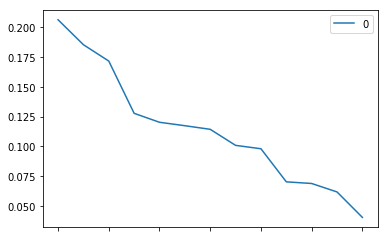

In [122]:
pca_nutri_df = pd.DataFrame(pca_nutri.components_, columns=norm_nutri_df.columns)
ex_var_nutri_df = (pd.DataFrame(pca_nutri.explained_variance_ratio_)).transpose()
feat_score_nutri = ex_var_nutri_df.dot(pca_nutri_df).abs()

plt.figure(figsize=(10,7))
feat_score_nutri.transpose().sort_values(by=0, ascending=False).plot()
plt.show()

In [74]:
feat_score_nutri.transpose().sort_values(by=0, ascending=False)

,0
energy_100g,0.230673
carbohydrates_100g,0.188434
fiber_100g,0.162170
fat_100g,0.128290
cal_density,0.115937
nutrition-score-uk_100g,0.112051
nutrition-score-fr_100g,0.107988
sugars_100g,0.099398
nutrition_grade_numeric,0.087418
saturated-fat_100g,0.081659


In [75]:
total_df = dataframe[['nutrition-score-fr_100g', 'nutrition-score-uk_100g',
       'nutrition_grade_numeric', 'serving_size', 'energy_100g', 'fat_100g',
       'saturated-fat_100g', 'proteins_100g', 'carbohydrates_100g',
       'sugars_100g', 'fiber_100g', 'cal_density', 'cal_deviation', 'Median revenue euros',
       'Total poverty rate (%)', 'Share of activity revenue (%)',
       'Share of retreat pension revenue (%)',
       'Share of heritage revenue and other (%)',
       'Share of social benefits revenue (%)', 'Share of taxes (%)']].dropna()
_, _, norm_tot_df = normalize(nutrition_df)

pca = PCA(n_components=0.95)
pca.fit(norm_tot_df)

print('Number of eigenvectors that explain 95% of the variance:', len(pca.explained_variance_ratio_))

Number of eigenvectors that explain 95% of the variance: 8


In [147]:
pd.DataFrame(pca.components_, columns=norm_nutri_df.columns)

,nutrition-score-fr_100g,nutrition-score-uk_100g,nutrition_grade_numeric,cal_density,cal_deviation,serving_size,energy_100g,fat_100g,saturated-fat_100g,proteins_100g,carbohydrates_100g,sugars_100g,fiber_100g
0,0.428311,0.434055,0.398514,0.031514,0.012804,-0.045233,0.352415,0.348999,0.337565,0.121550,0.179787,0.221140,0.100904
1,-0.096275,-0.121748,-0.097813,-0.054414,-0.079673,-0.103090,0.264298,-0.231976,-0.294012,-0.172423,0.561607,0.408970,0.473189
2,0.028995,0.005600,0.024070,0.695049,-0.020749,0.693761,0.009438,-0.054314,-0.038314,-0.130730,0.055755,0.094289,-0.011113
3,-0.212499,-0.125299,-0.265821,0.141597,-0.177411,0.059812,0.287320,0.235999,0.114008,0.577514,0.020163,-0.390557,0.419133
4,-0.039907,-0.036135,-0.031421,0.032971,0.974556,0.024940,0.025266,0.001737,-0.041673,0.158772,0.092348,-0.032391,0.086494
5,-0.182272,-0.160000,-0.257041,-0.015364,0.091331,-0.019519,0.151672,0.456541,0.385881,-0.676320,-0.053313,-0.076918,0.140150
6,-0.090244,0.003539,-0.203267,0.213343,-0.005013,-0.231677,0.485715,-0.007320,-0.082094,0.006972,0.340896,-0.148619,-0.685749
7,0.208165,0.050465,0.350974,-0.078824,0.003835,0.063843,0.136220,0.068398,-0.487414,-0.300812,0.079231,-0.662207,0.156662


In [153]:
selected_feat = feat_score_eco[feat_score_eco > 0.16].transpose().dropna().index
selected_feat = selected_feat.append(feat_score_nutri[feat_score_nutri > 0.16].transpose().dropna().index)

In [161]:
selected_df = dataframe[selected_feat].dropna()

# 4. Aggregation

Aggregation by geographic location (City, arrondissement, department or region) using 2 metrics: mean and median

**1. Mean**

In [25]:
dataframe_city = dataframe.drop(columns=['Region', 'custom_arrondissement_code', 'Department']
                               ).dropna().groupby('City name').mean()
dataframe_arr = dataframe.drop(columns=['Region', 'City name', 'Department']
                              ).dropna().groupby('custom_arrondissement_code').mean()
dataframe_dep = dataframe.drop(columns=['Region', 'custom_arrondissement_code', 'City name']
                              ).dropna().groupby('Department').mean()
dataframe_reg = dataframe.drop(columns=['Department', 'custom_arrondissement_code', 'City name']
                              ).dropna().groupby('Region').mean()

**2. Median**

In [26]:
dataframe_city_med = dataframe.drop(columns=['Region', 'custom_arrondissement_code', 'Department']
                                   ).dropna().groupby('City name').median()
dataframe_arr_med = dataframe.drop(columns=['Region', 'City name', 'Department']
                                  ).dropna().groupby('custom_arrondissement_code').median()
dataframe_dep_med = dataframe.drop(columns=['Region', 'custom_arrondissement_code', 'City name']
                                  ).dropna().groupby('Department').median()
dataframe_reg_med = dataframe.drop(columns=['Department', 'custom_arrondissement_code', 'City name']
                                  ).dropna().groupby('Region').median()

# 5. Clustering

In [29]:
nutri_cols = ['nutrition-score-fr_100g', 'nutrition-score-uk_100g',
              'nutrition_grade_numeric', 'serving_size', 'energy_100g', 'fat_100g',
              'saturated-fat_100g', 'proteins_100g', 'carbohydrates_100g','sugars_100g', 
              'fiber_100g', 'cal_density', 'cal_deviation']

**1. Cities**

In [30]:
def plot_scatter(df):
    fig, axs = plt.subplots(4, 4, figsize=(25, 25))
    fig.suptitle("Scatter plots of the relationships between each nutrition attribute and the Median Revenue", 
                fontweight="bold")
    i = 0;
    j = 0;
    count = 1;
    for col in nutri_cols:
        df.plot.scatter(x='Median revenue euros', y=col, ax=axs[i, j])
        axs[i, j].set_title(col)
        if count % 4 == 0:
            i = i + 1;
        j = (j + 1) % 4;
        count = count + 1
    fig.show()

/home/wilhelm/Documents/EPFL/applied_data_analysis/.env/lib/python3.6/site-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


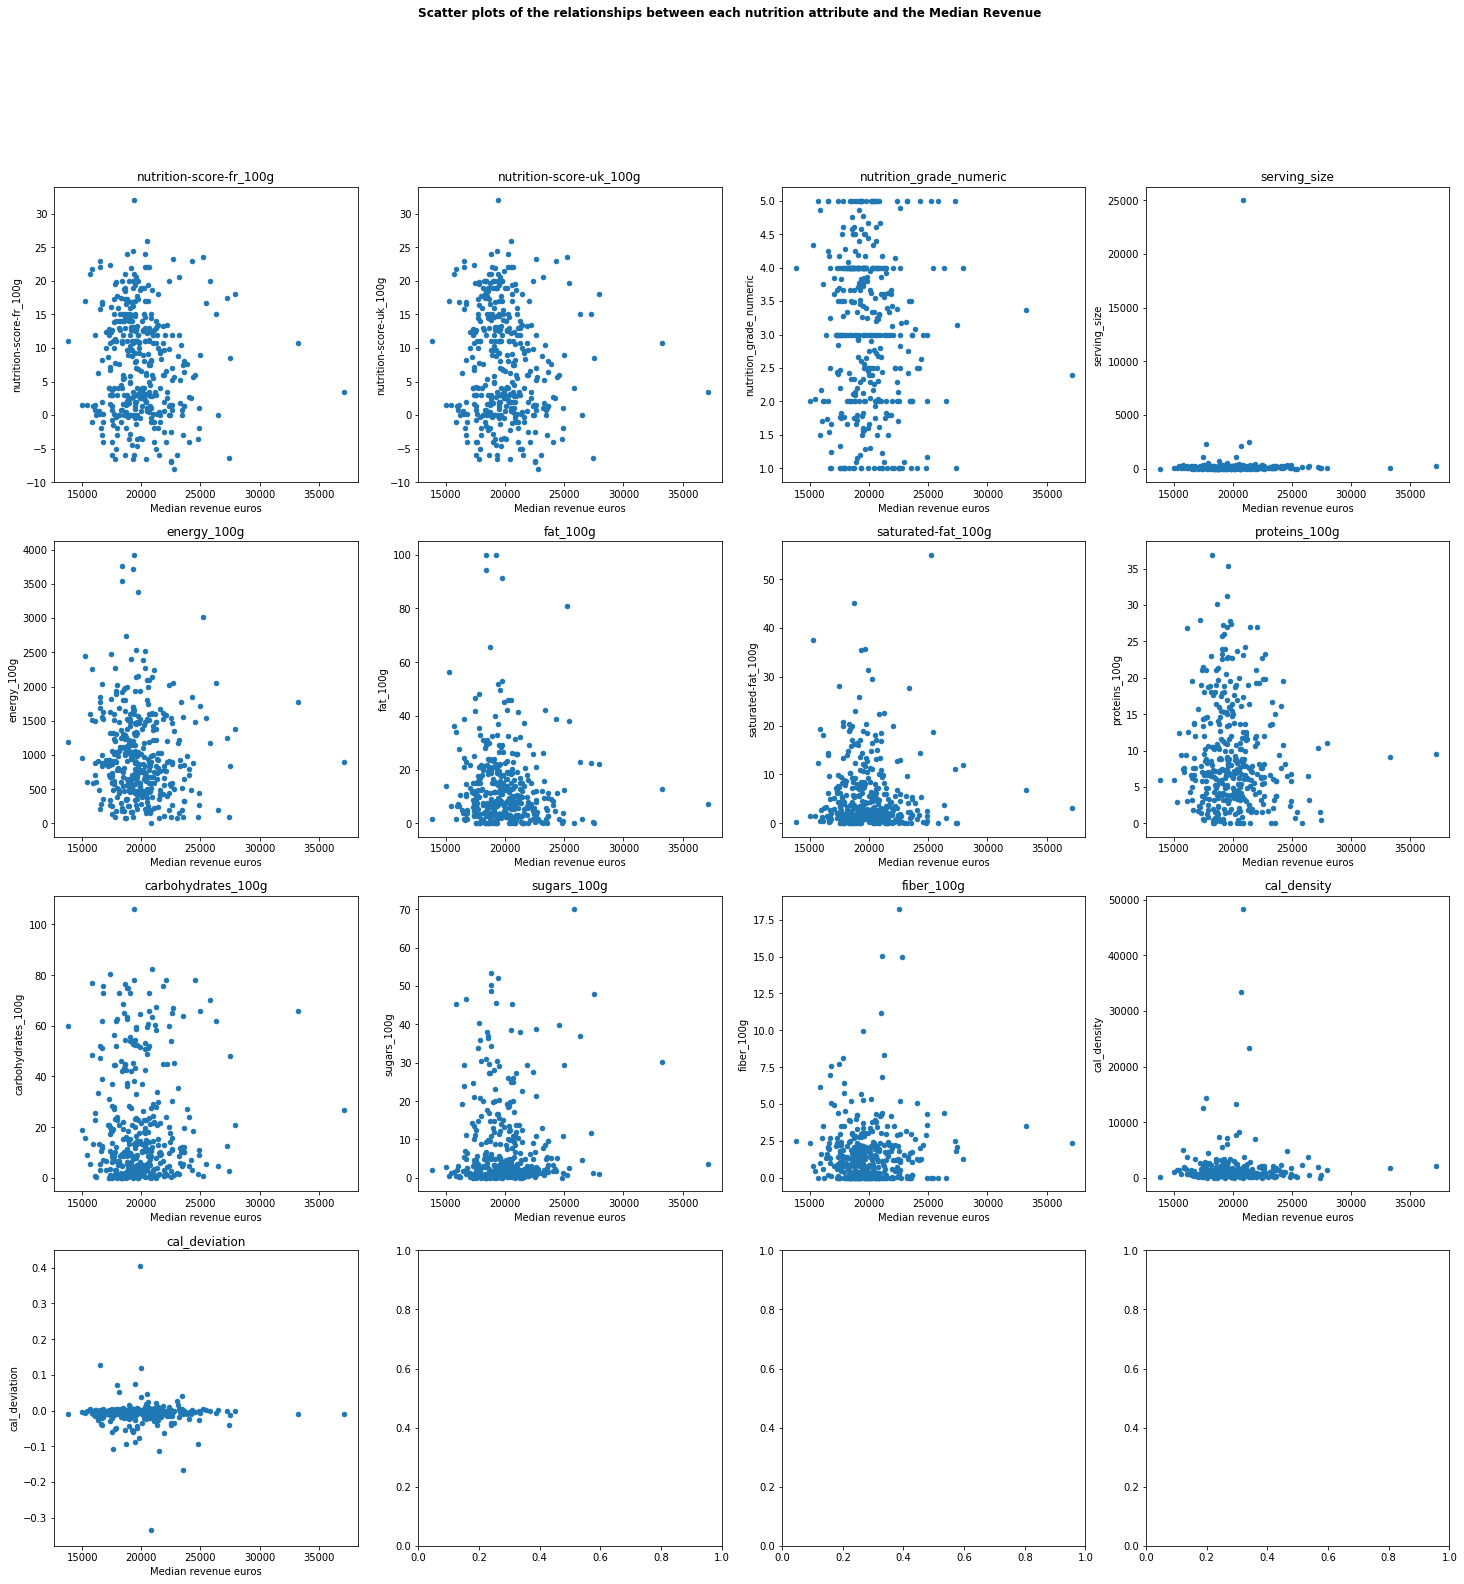

In [31]:
plot_scatter(dataframe_city)

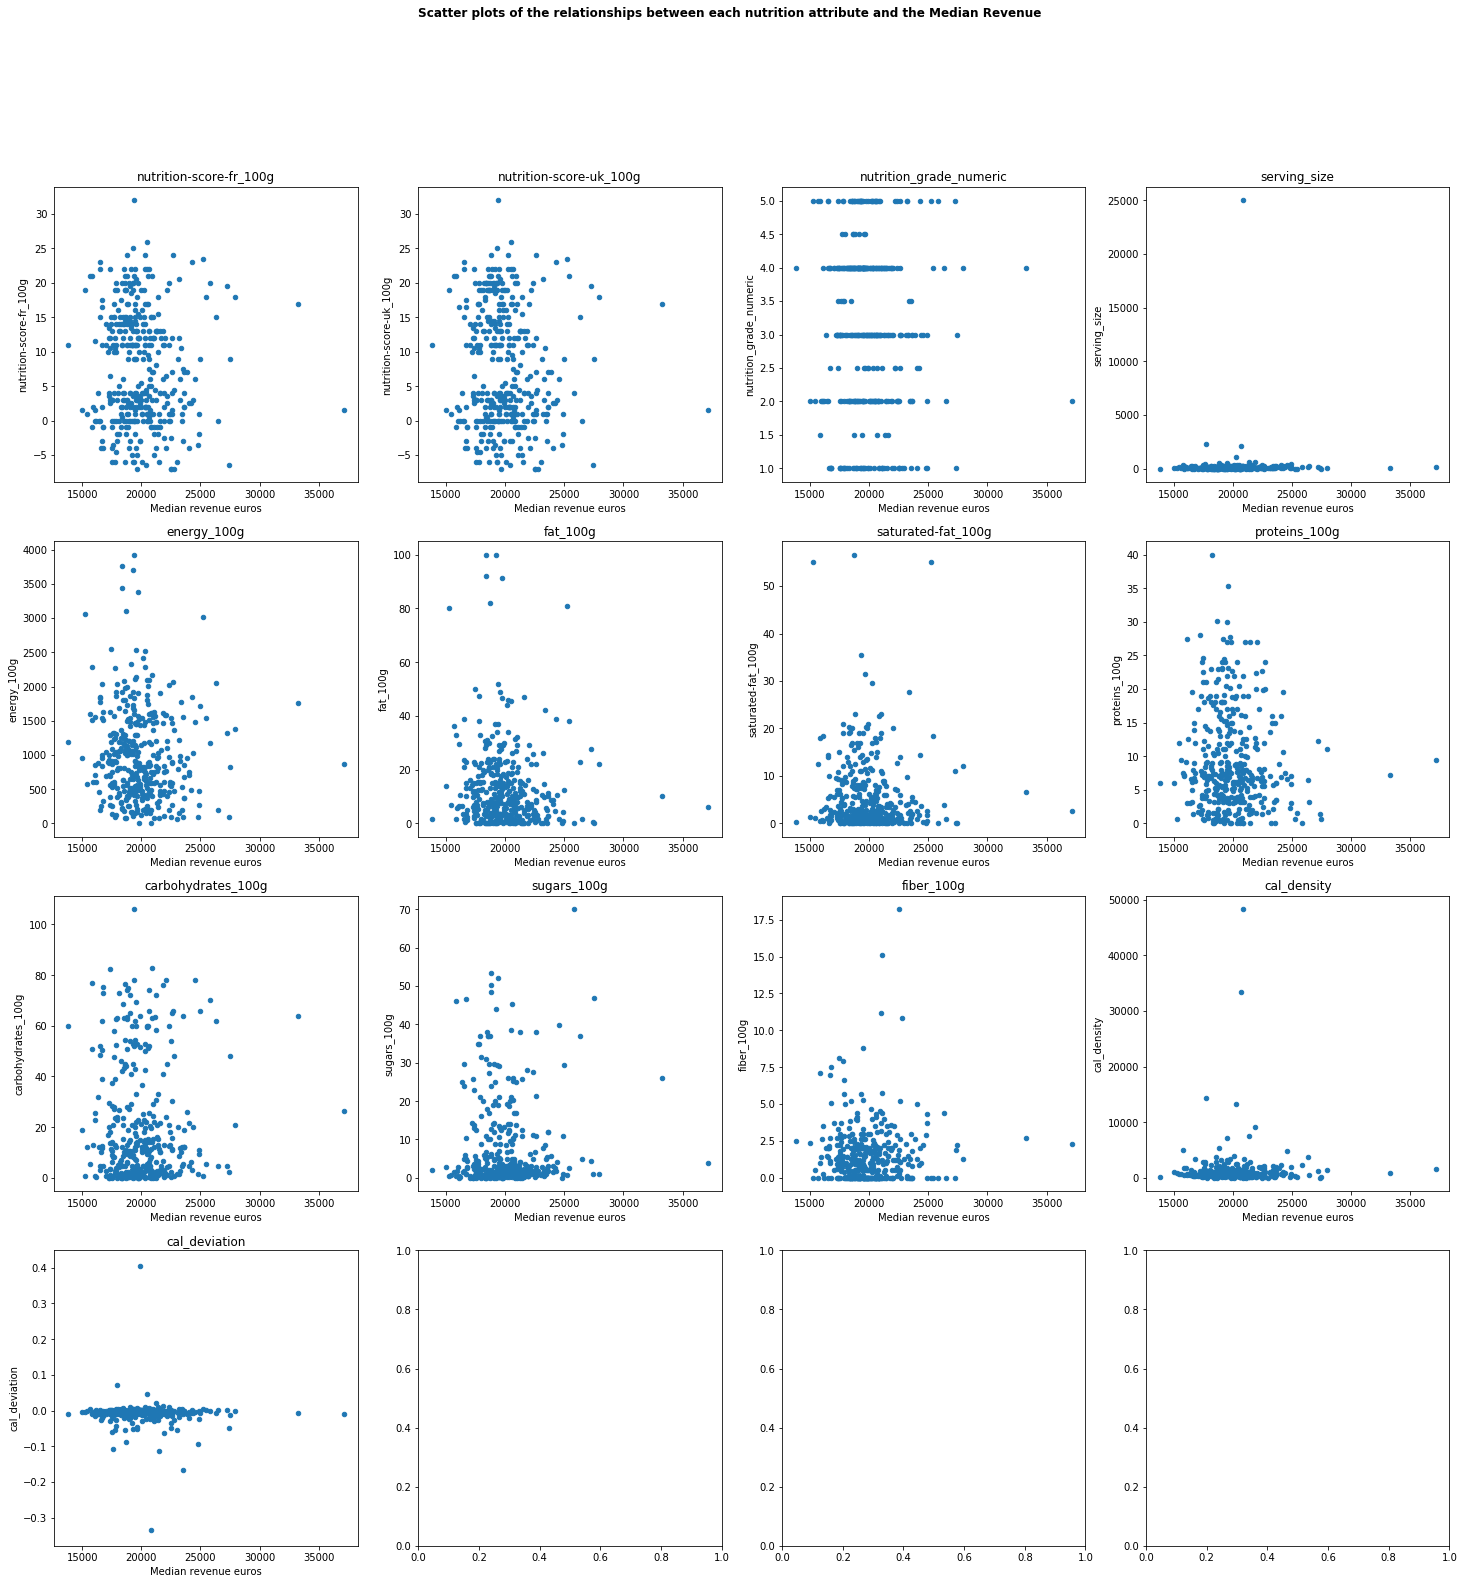

In [32]:
plot_scatter(dataframe_city_med)

**2. Arrondissements**

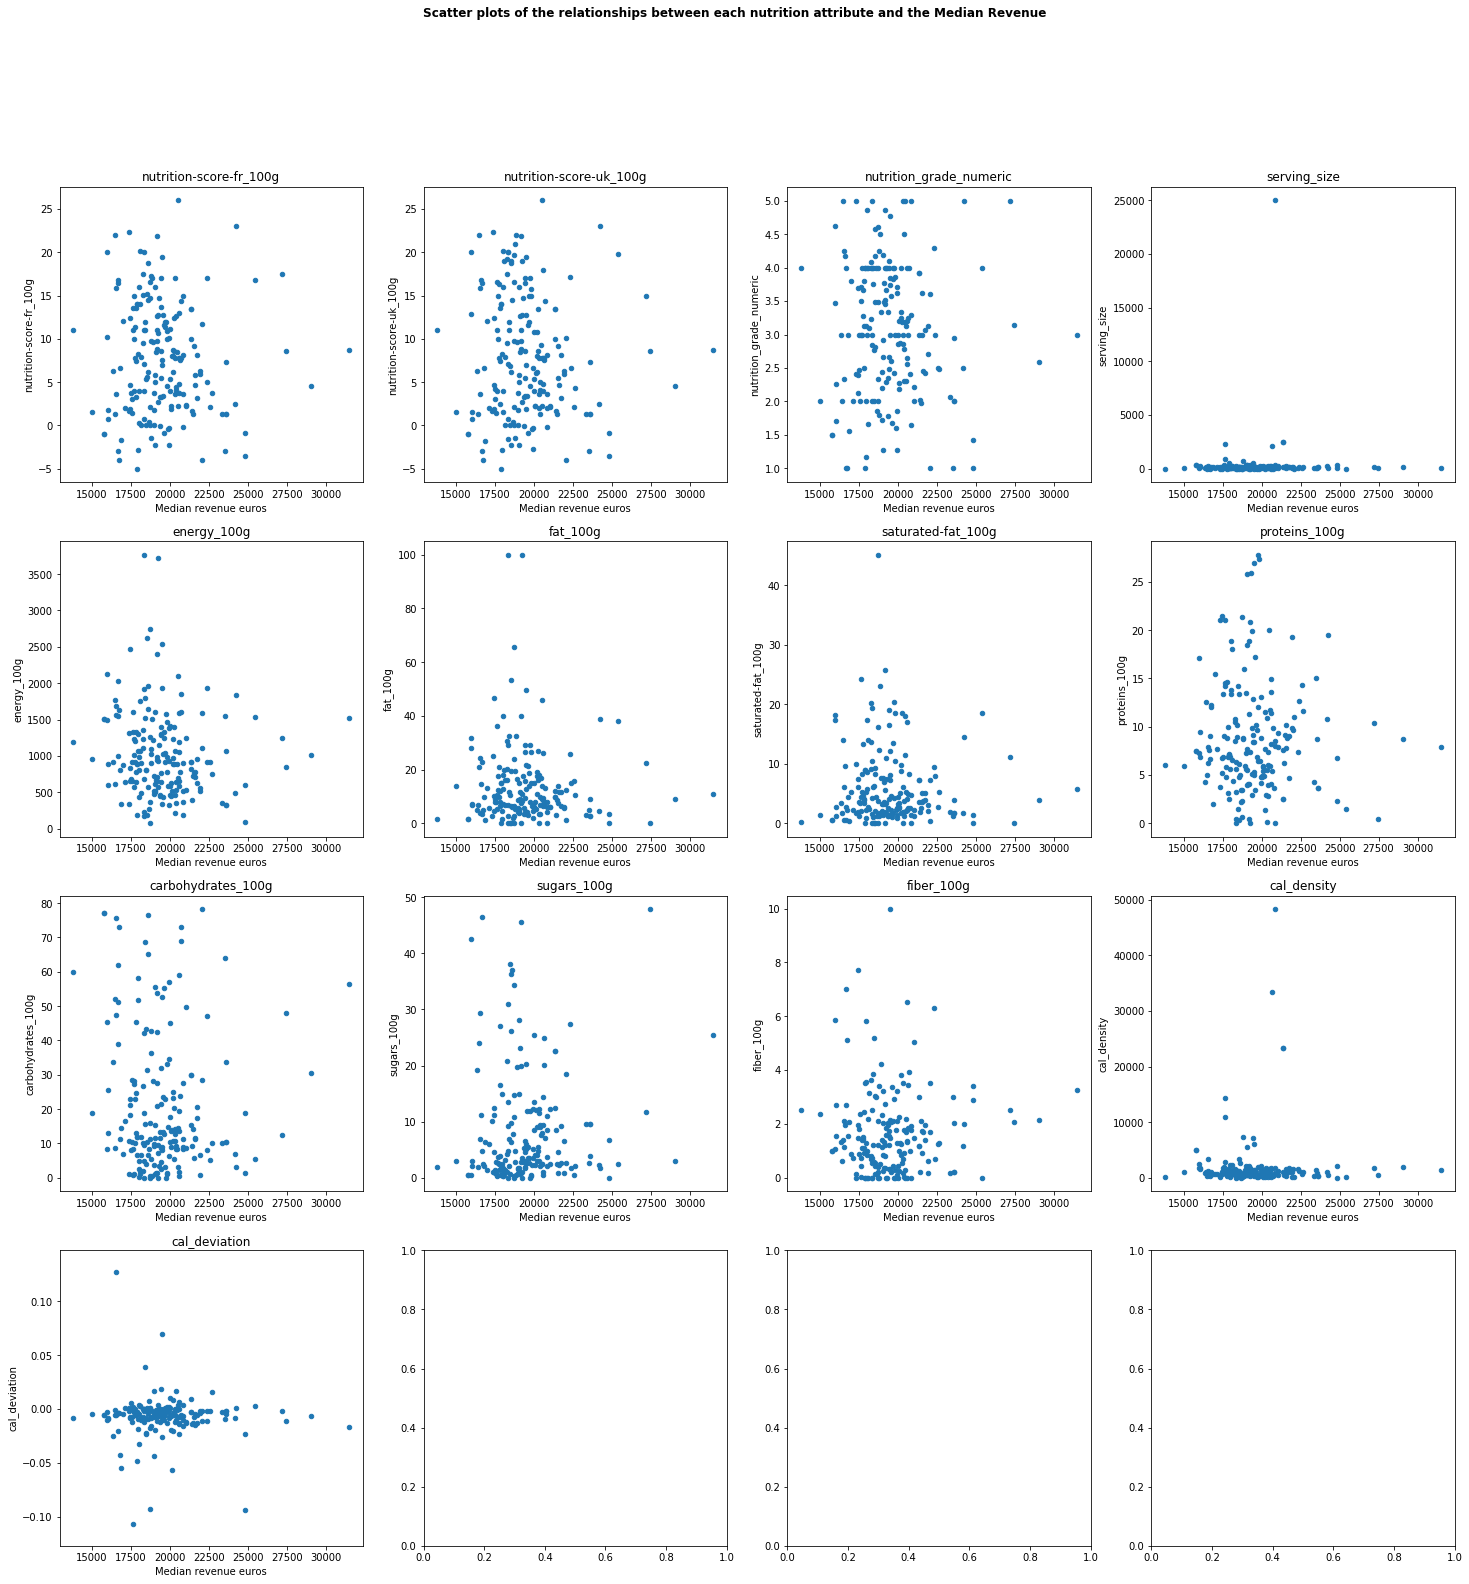

In [33]:
plot_scatter(dataframe_arr)

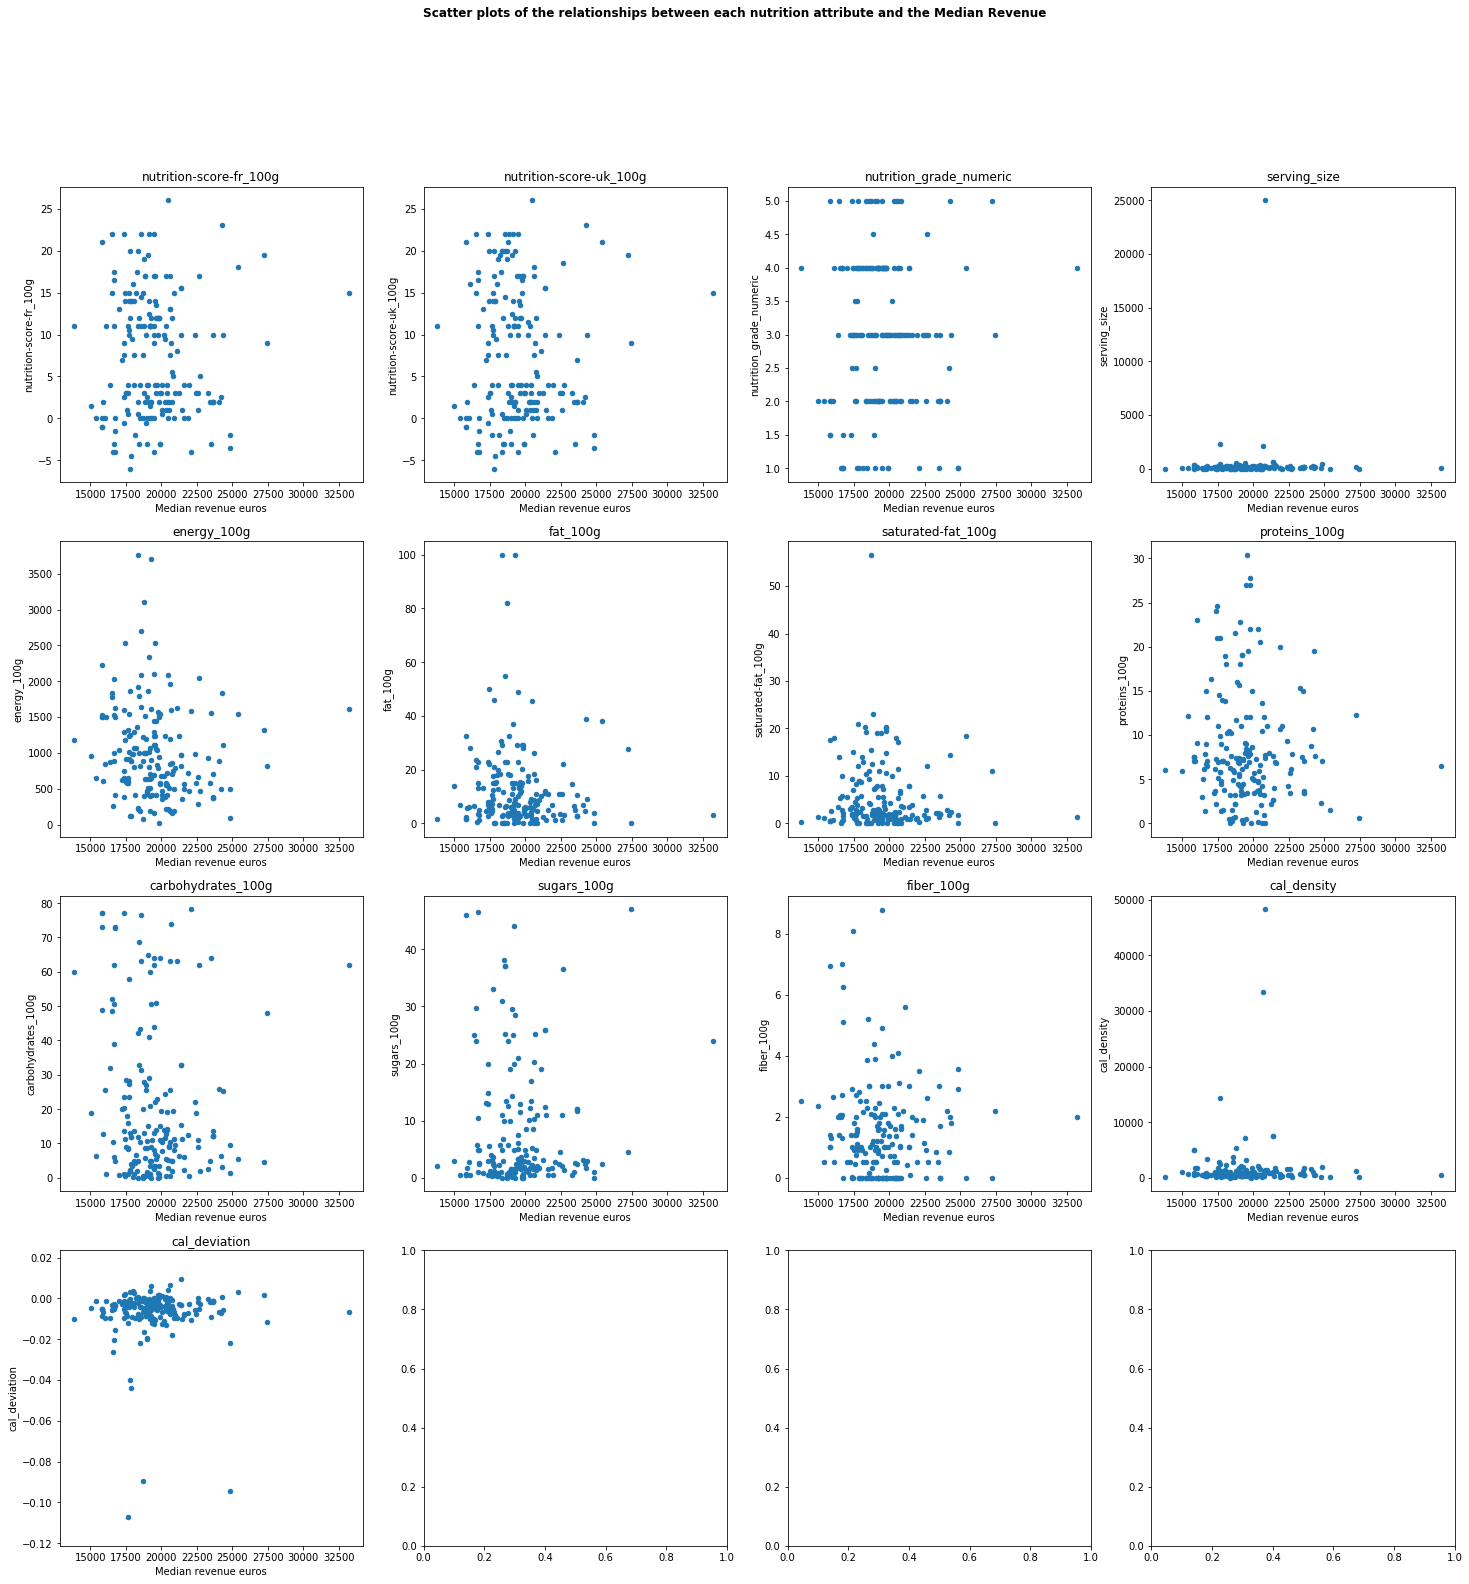

In [34]:
plot_scatter(dataframe_arr_med)

**3. Departments**

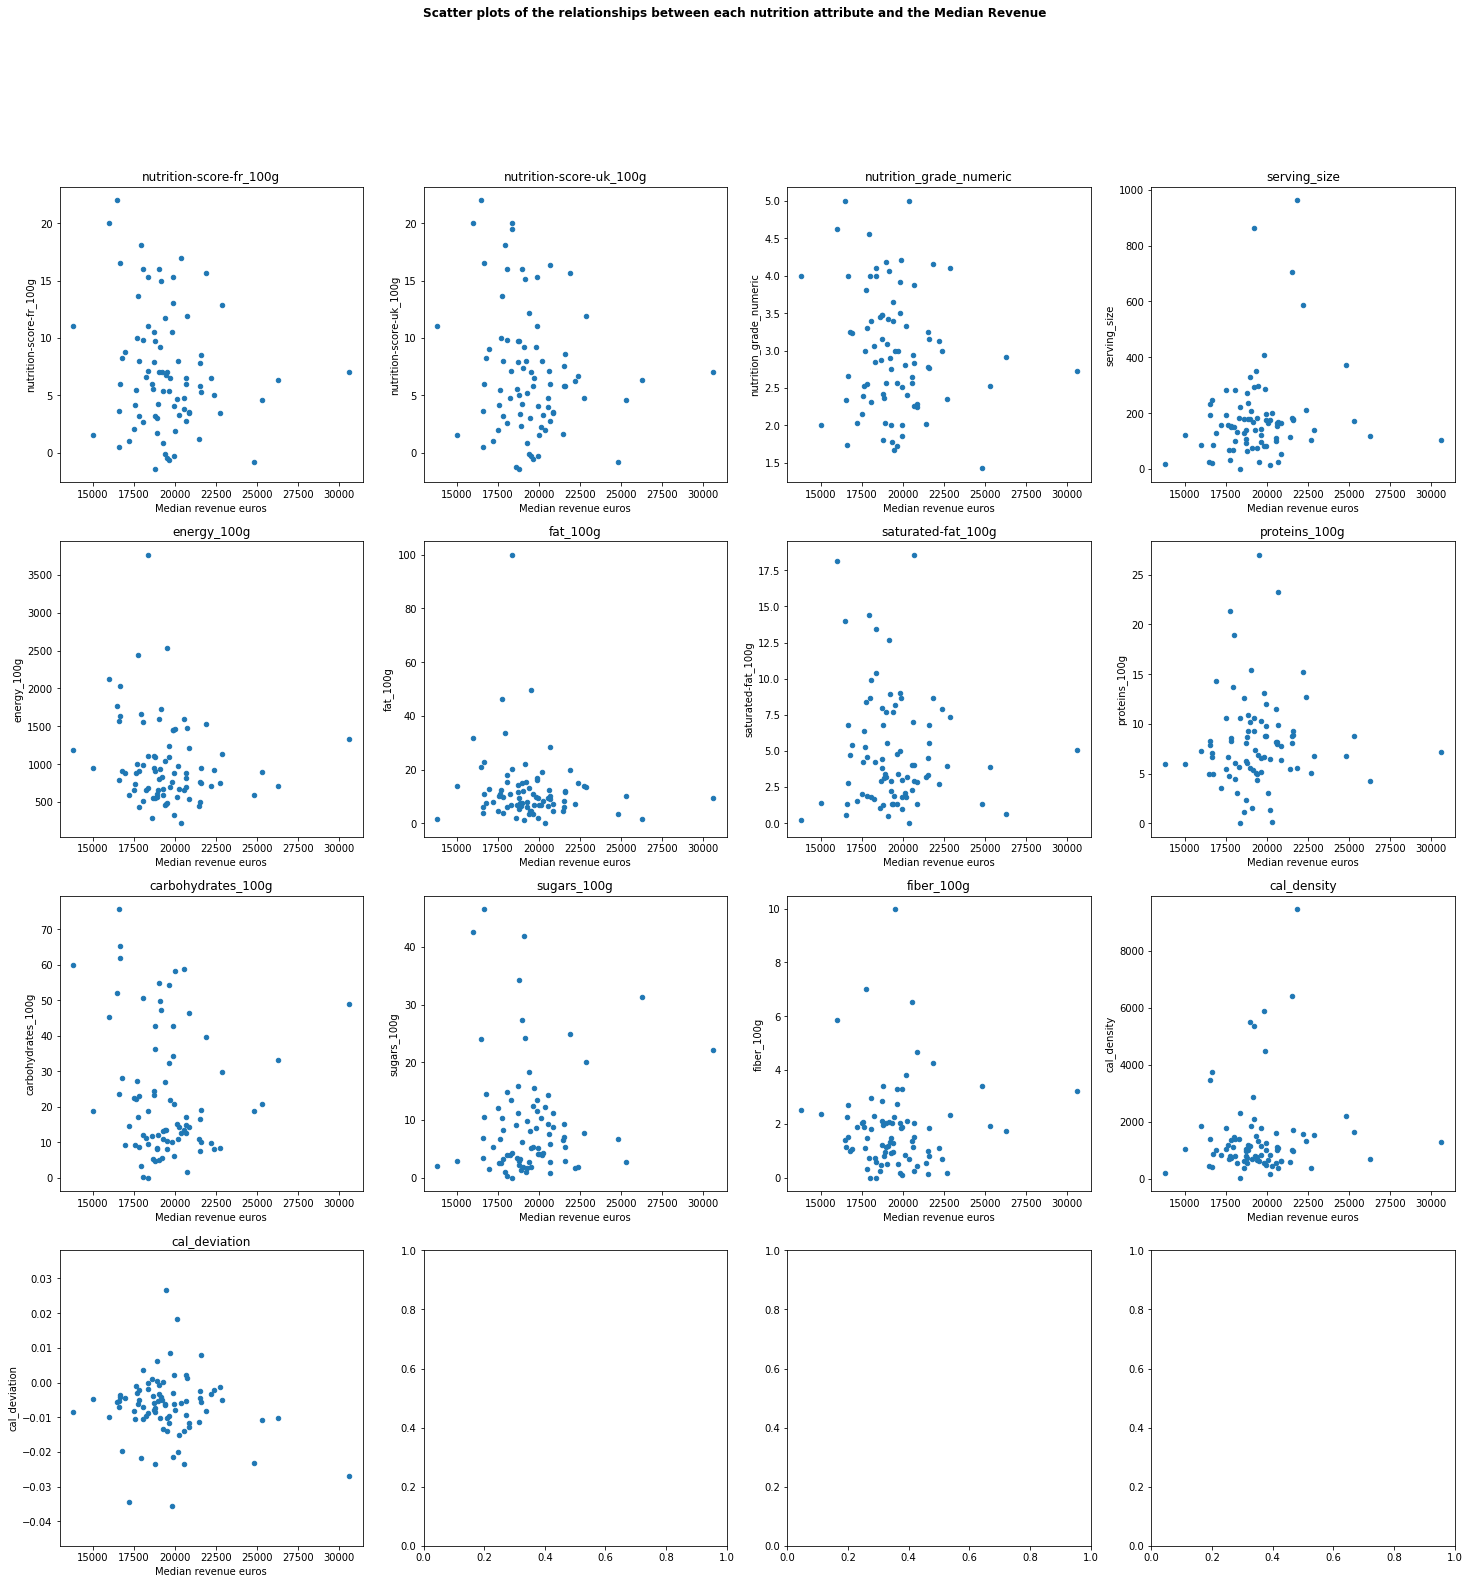

In [35]:
plot_scatter(dataframe_dep)

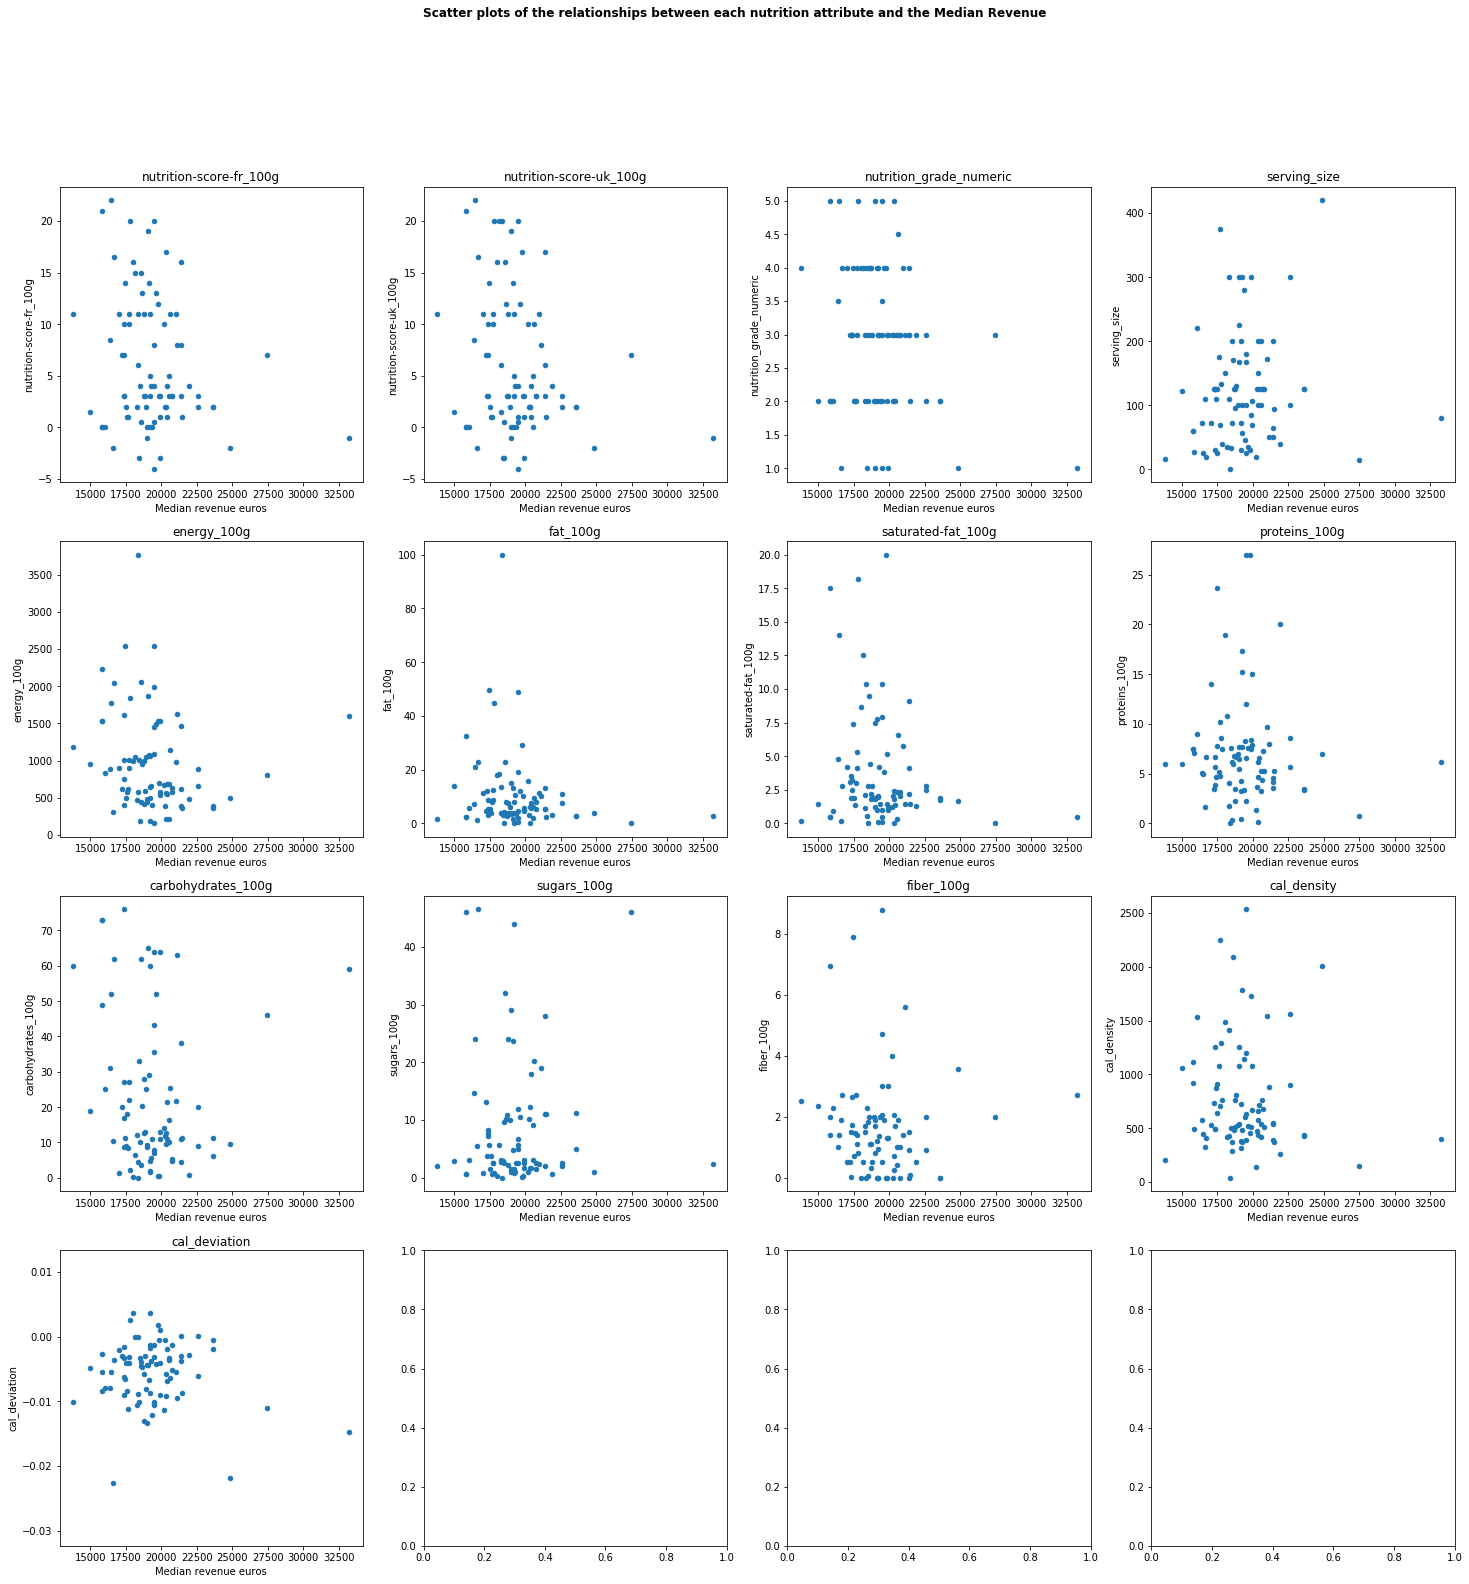

In [36]:
plot_scatter(dataframe_dep_med)

**4. Regions**

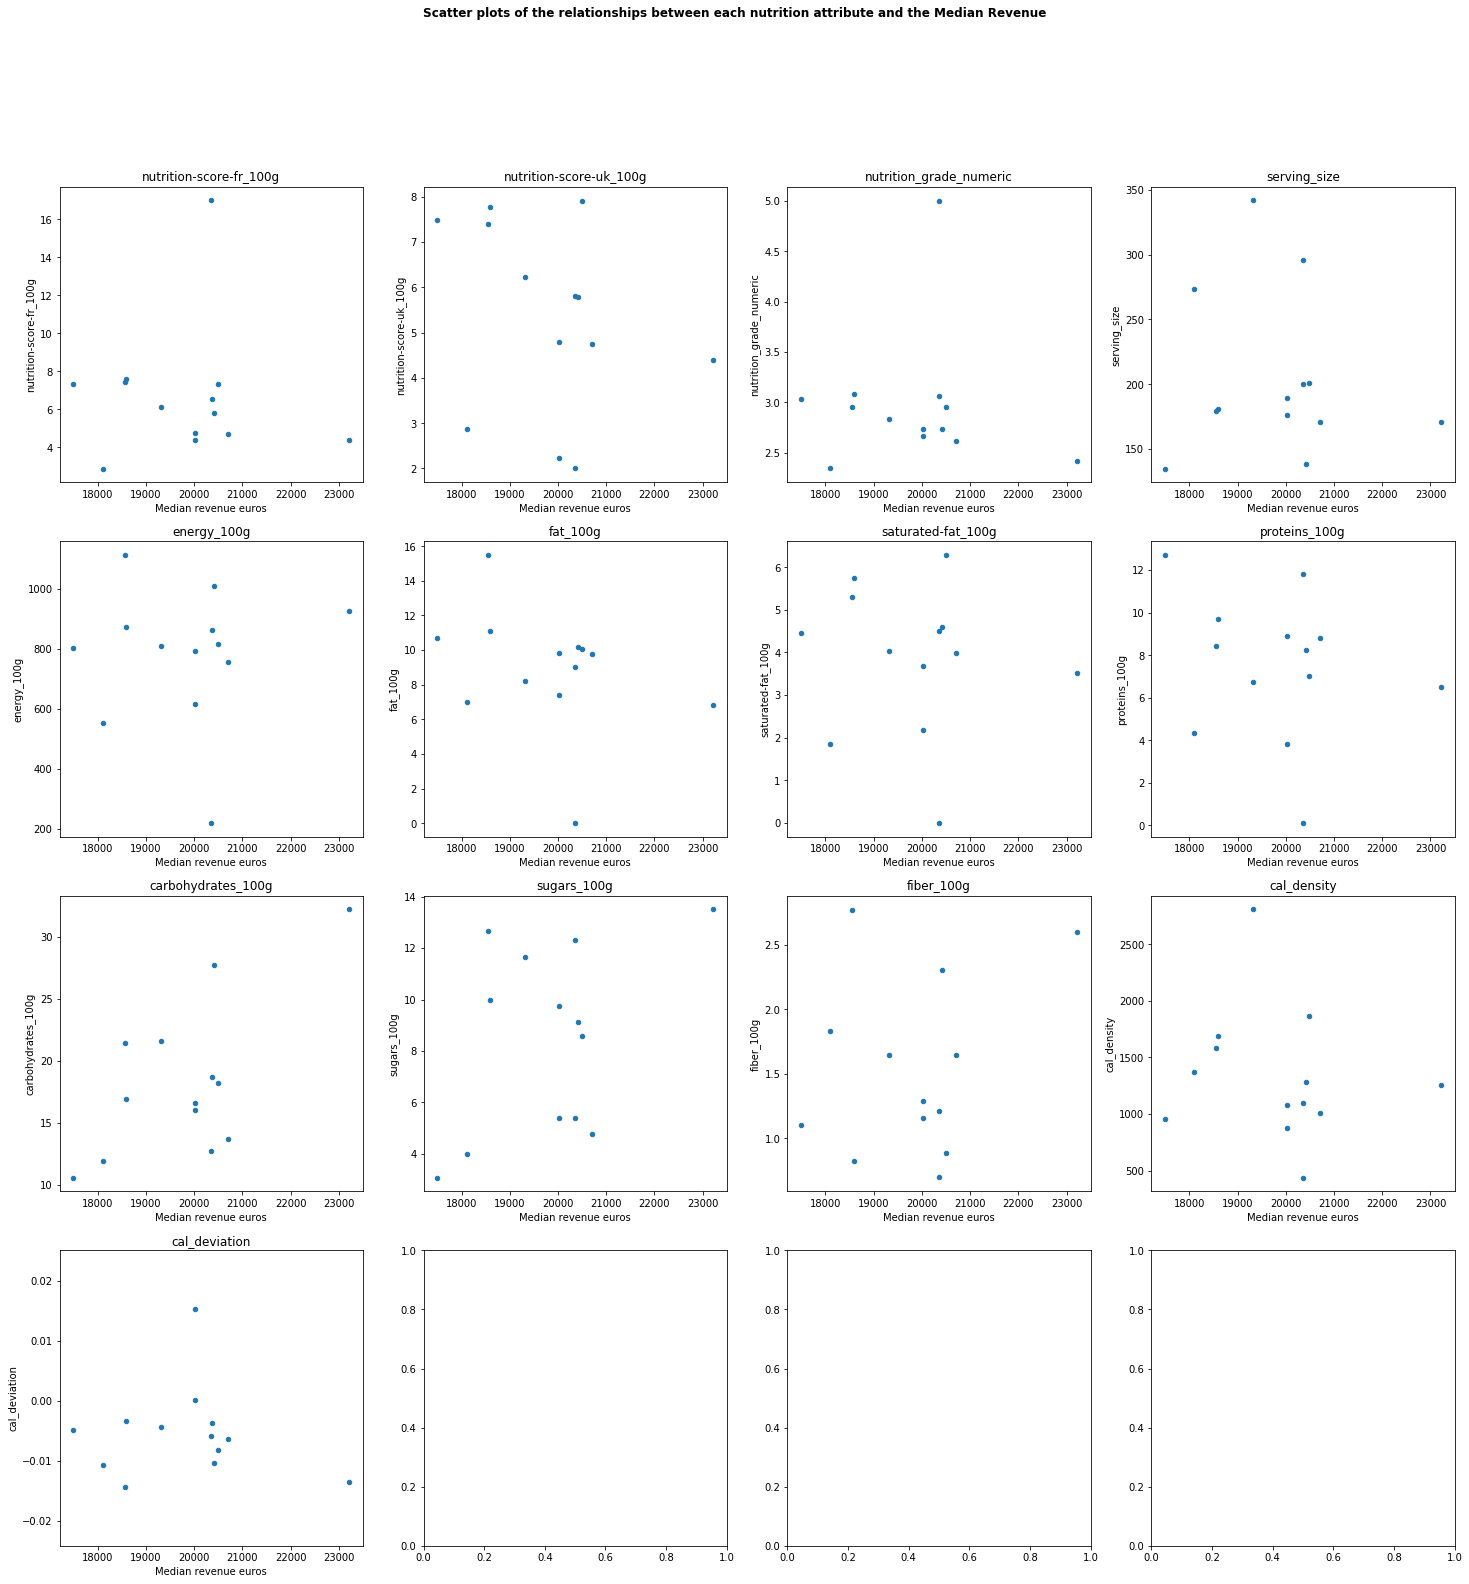

In [37]:
plot_scatter(dataframe_reg)

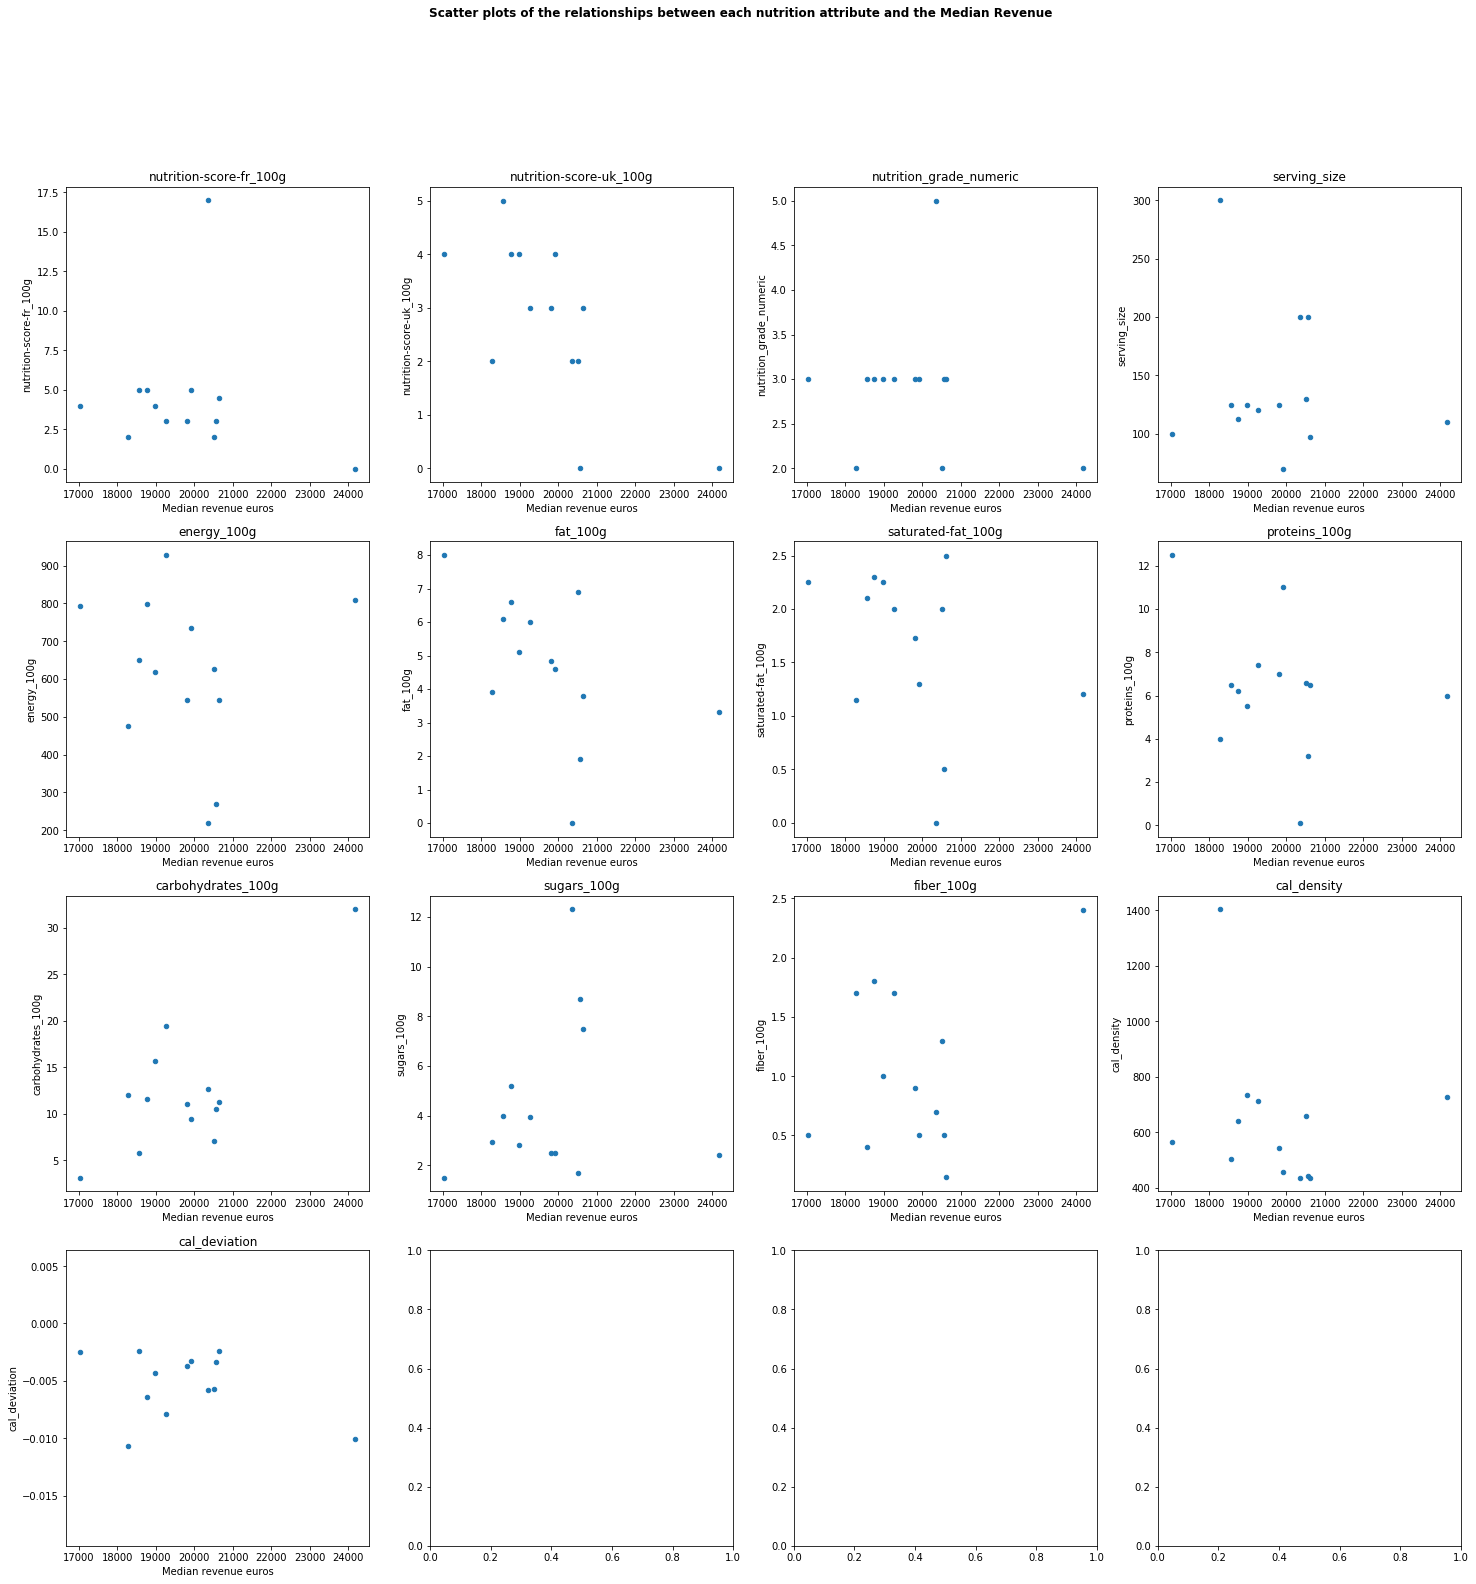

In [38]:
plot_scatter(dataframe_reg_med)

In [39]:
def cluster(df, eps, min_samples):
    # Normalize
    X = StandardScaler().fit_transform(df)

    # Compute DBSCAN
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(X)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    print('Estimated number of clusters: %d' % n_clusters_)
    print('Estimated number of noise points: %d' % n_noise_)
    print("Silhouette Coefficient: %0.3f"
          % metrics.silhouette_score(X, labels))

    # Plot result
    # Black removed and is used for noise instead.
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each)
              for each in np.linspace(0, 1, len(unique_labels))]
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_member_mask = (labels == k)

        xy = X[class_member_mask & core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=14)

        xy = X[class_member_mask & ~core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=6)

    plt.title('Estimated number of clusters: %d' % n_clusters_)
    plt.show()
    
    return labels

Estimated number of clusters: 32
Estimated number of noise points: 0
Silhouette Coefficient: -0.173


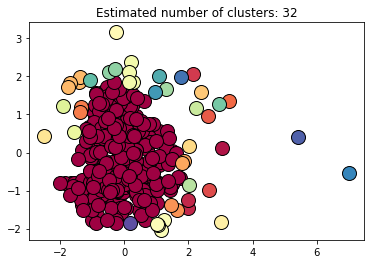

In [40]:
labels = cluster(dataframe_city[['Median revenue euros', 'nutrition-score-fr_100g']], 0.3, 1)

In [41]:
labels = cluster(dataframe_arr[['Median revenue euros', 'nutrition-score-fr_100g']], 3, 10)

Estimated number of clusters: 1
Estimated number of noise points: 0


ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

In [42]:
labels = cluster(dataframe_dep[['Median revenue euros', 'nutrition-score-fr_100g']], 3, 2)

Estimated number of clusters: 1
Estimated number of noise points: 0


ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

In [43]:
labels = cluster(dataframe_reg[['Median revenue euros', 'energy_100g']], 100, 1)

Estimated number of clusters: 1
Estimated number of noise points: 0


ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

# 6. Correlation analysis 

In [44]:
def plot_corr_matrix(df1, df2, geography):
    corr1 = df1.corr()
    corr2 = df2.corr()
    names1 = list(corr1.columns)
    names2 = list(corr1.columns)
    # plot correlation matrix
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5.5))
    f.suptitle("Correlation matrix for " + geography, y=1.3, fontweight="bold")
    
    cax1 = ax1.matshow(corr1, vmin=-1, vmax=1)
    ticks1 = np.arange(0, len(names1), 1)
    ax1.set_xticks(ticks1)
    ax1.set_yticks(ticks1)
    ax1.set_xticklabels(names1)
    ax1.set_yticklabels(names1)
    ax1.tick_params(axis='x', labelrotation=90)
    ax1.set_title('Mean', y=1.45)
    
    cax2 = ax2.matshow(corr2, vmin=-1, vmax=1)
    ticks2 = np.arange(0, len(names2), 1)
    ax2.set_xticks(ticks2)
    ax2.set_yticks(ticks2)
    ax2.set_xticklabels(names2)
    ax2.set_yticklabels(names2)
    ax2.tick_params(axis='x', labelrotation=90)
    ax2.set_title('Median', y=1.45)
    
    f.colorbar(cax1)
    plt.show()

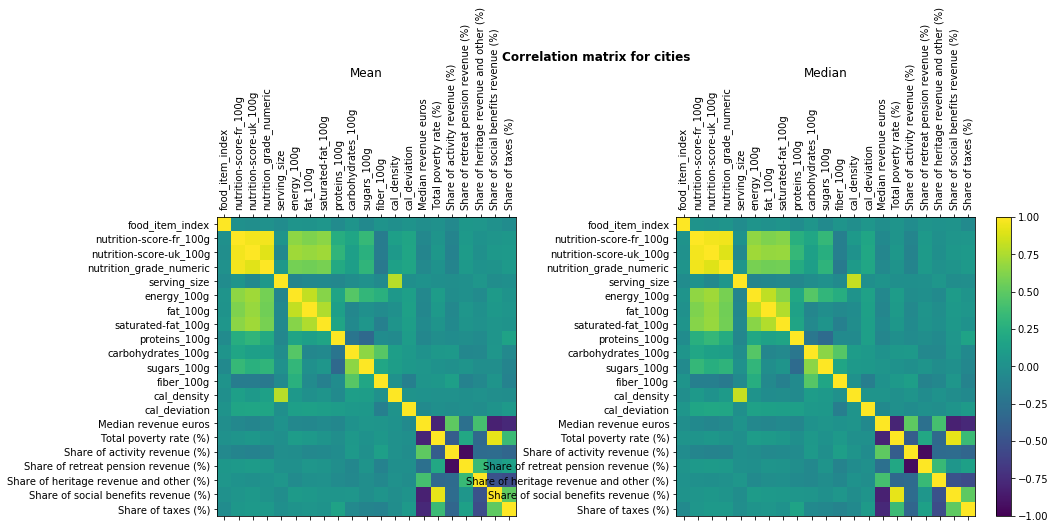

In [45]:
plot_corr_matrix(dataframe_city, dataframe_city_med, "cities")

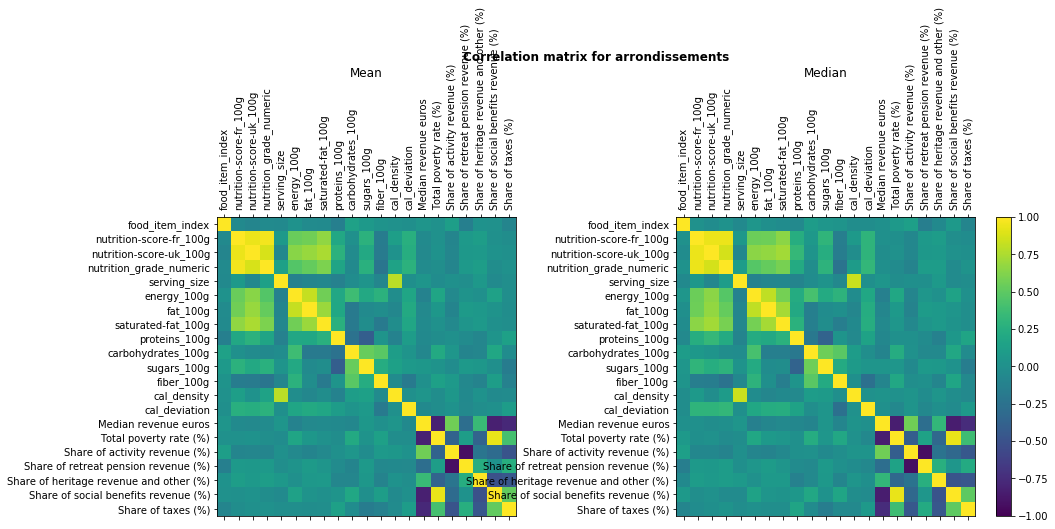

In [46]:
plot_corr_matrix(dataframe_arr, dataframe_arr_med, "arrondissements")

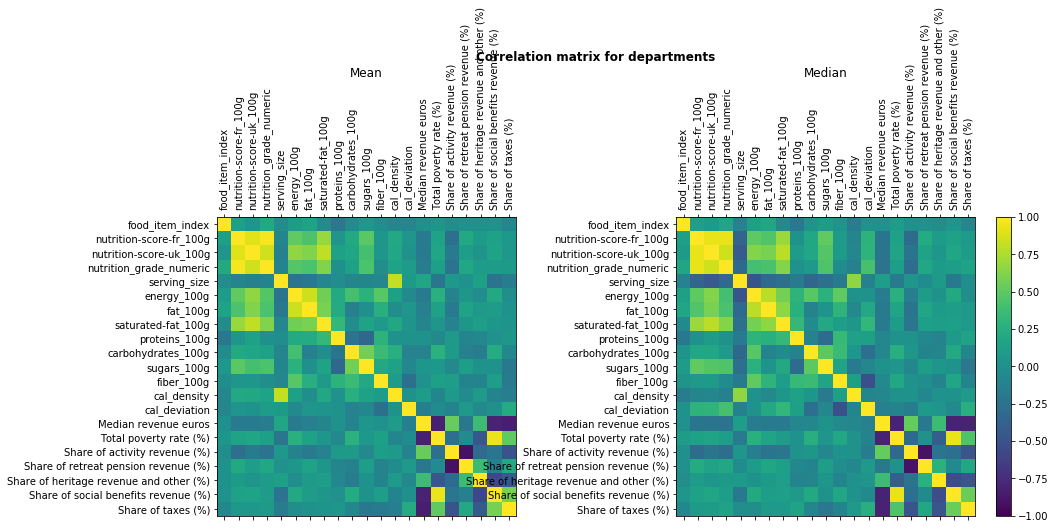

In [47]:
plot_corr_matrix(dataframe_dep, dataframe_dep_med, "departments")

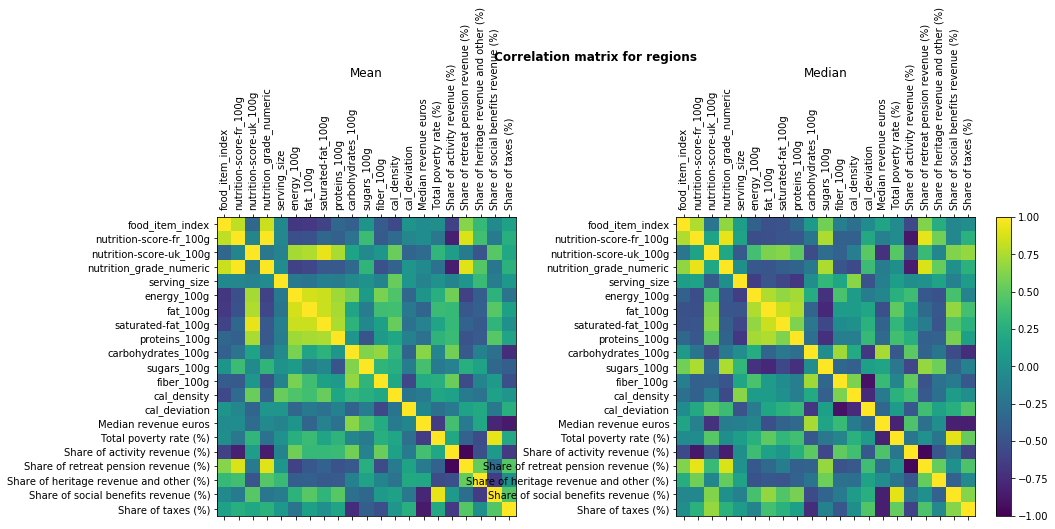

In [48]:
plot_corr_matrix(dataframe_reg, dataframe_reg_med, "regions")

Hooray, we found something at the region level! Let's see more closely how significant it is:

In [52]:
def pearson_pval_df(df):
    for col in df.columns:
        if col != 'Median revenue euros' and col != 'food_item_index' and col != 'Region':
            r, p = stats.pearsonr(df[col], df['Median revenue euros'])
            print('{:<30}{:<16}{:<28.3f}{:<10}{:<30.3f}'.format(col, 'Pearson coeff', r, 'p-value', p))

In [53]:
pearson_pval_df(dataframe_reg)

nutrition-score-fr_100g       Pearson coeff   -0.031                      p-value   0.921                         
nutrition-score-uk_100g       Pearson coeff   -0.299                      p-value   0.321                         
nutrition_grade_numeric       Pearson coeff   -0.040                      p-value   0.897                         
serving_size                  Pearson coeff   -0.103                      p-value   0.737                         
energy_100g                   Pearson coeff   0.034                       p-value   0.911                         
fat_100g                      Pearson coeff   -0.346                      p-value   0.248                         
saturated-fat_100g            Pearson coeff   -0.111                      p-value   0.719                         
proteins_100g                 Pearson coeff   -0.244                      p-value   0.421                         
carbohydrates_100g            Pearson coeff   0.643                       p-valu

In [54]:
pearson_pval_df(dataframe_reg_med)

nutrition-score-fr_100g       Pearson coeff   -0.127                      p-value   0.680                         
nutrition-score-uk_100g       Pearson coeff   -0.710                      p-value   0.007                         
nutrition_grade_numeric       Pearson coeff   -0.162                      p-value   0.596                         
serving_size                  Pearson coeff   -0.134                      p-value   0.662                         
energy_100g                   Pearson coeff   -0.085                      p-value   0.783                         
fat_100g                      Pearson coeff   -0.512                      p-value   0.074                         
saturated-fat_100g            Pearson coeff   -0.364                      p-value   0.221                         
proteins_100g                 Pearson coeff   -0.313                      p-value   0.297                         
carbohydrates_100g            Pearson coeff   0.740                       p-valu

From the mean dataframe, the columns for which the correlation with the Median revenue is significant (i.e. the corresponding p-value is below 0.05) are:

* nutrition-score-fr_100g          
* nutrition-score-uk_100g  
* nutrition_grade_numeric  
* serving_size             
* energy_100g              
* fat_100g                 
* saturated-fat_100g   
* sugars_100g
* cal_density       
* cal_deviation     

For all these columns, we have a negative correlation between each of them and the mean median revenue for the overall region. The Pearson coefficients are all below the -0.3 threshold that allows us to claim that there is a correlation. 
The Pearson coefficients are actually below -0.5 for each of these columns.

The negative correlation is more significant for sugars, fat, saturated fat, the nutrition scores and the calory density (coefficient around **-0.7 / -0.8**).

For the median dataframe, we can observe the same tendencies. 

# 7. Vizzzzzzzzz

We only found an actual relationship for regions so this is what we're gonna viz.

First we have to reset the indexes.

In [55]:
dataframe_reg.reset_index(inplace=True)
dataframe_reg_med.reset_index(inplace=True)

Then we have to transform the 'Region' column from int to string and add a 0 if the region number only has one character.

In [56]:
dataframe_reg['Region'] = dataframe_reg['Region'].apply(lambda x : str(x))
dataframe_reg['Region'] = dataframe_reg['Region'].apply(lambda x : '0'+x if len(x) == 1 else x)

dataframe_reg_med['Region'] = dataframe_reg['Region'].apply(lambda x : str(x))
dataframe_reg_med['Region'] = dataframe_reg['Region'].apply(lambda x : '0'+x if len(x) == 1 else x)

Region borders

In [58]:
# geojson: https://github.com/gregoiredavid/france-geojson
reg_borders = json.load(open("../data/raw/regions-avec-outre-mer.geojson"))

And now the viz:

In [59]:
for column in ['nutrition_grade_numeric', 'nutrition-score-fr_100g', 'nutrition-score-uk_100g']:
    map_nutrition = folium.Map(location=[46.5, 2.3], tiles='cartodbpositron', zoom_start=6)
    scale = np.linspace(np.min(dataframe_reg[column]), np.max(dataframe_reg[column]), 6)
    map_nutrition.choropleth(geo_data=reg_borders, 
                           data=dataframe_reg, 
                           columns=['Region', column],
                           key_on='feature.properties.code',
                           legend_name=column,
                           threshold_scale=list(scale),
                           fill_color='OrRd',fill_opacity=0.7, line_opacity=0.2,
                      )

    map_nutrition.save("../data/processed/map_{}.html".format(column))
    display(HTML("<a href='../data/processed/map_{0}.html' target='_blank'>{0}</a>".format(column)))

In [60]:
map_revenue = folium.Map(location=[46.5, 2.3], tiles='cartodbpositron', zoom_start=6)
scale = np.linspace(np.min(dataframe_reg['Median revenue euros']), np.max(dataframe_reg['Median revenue euros']), 6)
map_revenue.choropleth(geo_data=reg_borders, 
                       data=dataframe_reg, 
                       columns=['Region', 'Median revenue euros'],
                       key_on='feature.properties.code',
                       legend_name='Median revenue euros',
                       threshold_scale=list(scale),
                       fill_color='OrRd',fill_opacity=0.7, line_opacity=0.2,
                  )

map_revenue.save("../data/processed/map_{}.html".format('Median revenue euros'))
display(HTML("<a href='../data/processed/map_{0}.html' target='_blank'>{0}</a>".format('Median revenue euros')))

# Old analysis

In [268]:
def analyse_for_area(area_column, area_name, revenue_column, limit=10):
    """Performs the analysis for a type of area (city, region, ...)
    
    Arguments:
    -----------
    area_column: string
        Name of the column for the wanted type of area.
    area_name: string
        Name of the wanted type of area.
    limit: int
        Number of areas to consider.
    revenue_column: string
        Name of the revenue-related column to consider.
    """
    # group the products by area
    freq_df = dummy_df.groupby(area_column).count().sort_values(by=['food_item_index'], ascending=False)
    # take the limit areas with the most available data
    first_ten = list(freq_df[:limit].index)
    # initial dataset limited to the above selected areas
    rev_df = dummy_df[dummy_df[area_column].apply(lambda x: x in first_ten)]
    dummies = pd.get_dummies(rev_df, columns=['nutrition_grade_numeric'])
    
    list_dummy_grades = ['nutrition_grade_numeric_0', 'nutrition_grade_numeric_1',
                         'nutrition_grade_numeric_2', 'nutrition_grade_numeric_3',
                         'nutrition_grade_numeric_4', 'nutrition_grade_numeric_5']
    # compute the frequency of each grade per area
    frequency = dummies.groupby(area_column).sum()[list_dummy_grades]
    revenue = dummies.groupby(area_column).mean()[['food_item_index', revenue_column]]
    example = frequency.join(revenue, how='inner').sort_values(by=[revenue_column], ascending=False)
    
    # take the two most different areas
    area_1 = example.iloc[[0]][list_dummy_grades]
    area_2 = example.iloc[[limit - 1]][list_dummy_grades]
    
    # plot the distribution for each of the selected area
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
    fig.suptitle("Distribution of the nutrition grades' frequencies for 2 {}".format(area_name),
                 y=1.08, fontweight="bold")
    area_1.plot.bar(ax=ax1)
    ax1.set_title("{} 1: {} = {} €".format(area_name, revenue_column,
                                           list(example.iloc[[0]][revenue_column].values)[0]))
    area_2.plot.bar(ax=ax2)
    ax2.set_title("{} 2: {} = {} €".format(area_name, revenue_column, 
                                           list(example.iloc[[limit - 1]][revenue_column].values)[0]))
    plt.show()
    
    print("Mean: ")
    print(rev_df.groupby(area_column).mean().sort_values(
        by=revenue_column, ascending=False
    ).iloc[[0, limit - 1]]['nutrition_grade_numeric'])
    
    print("Median: ")
    print(rev_df.groupby(area_column).median().sort_values(
        by=revenue_column, ascending=False
    ).iloc[[0, limit - 1]]['nutrition_grade_numeric'])
    
    # Find median values for nutrition grade and revenue and plot them
    rev_grade = dummy_df.groupby(area_column).median()
    rev_grade.plot.scatter(x=revenue_column, y='nutrition_grade_numeric', figsize=(10, 6))
    rev_grade.boxplot(column=[revenue_column], by=['nutrition_grade_numeric'], vert=False, figsize=(10, 6))
    
    # Find ares that have at least 30 products within it
    nb_products = dummy_df.groupby(area_column).count()[['food_item_index']]
    nb_products = nb_products[nb_products['food_item_index'] > 30]
    list(nb_products.index)
    dummy_sup_30 = dummy_df[dummy_df[area_column].apply(lambda x : x in list(nb_products.index))]
    rev_grade_sup_30 = dummy_sup_30.groupby(area_column).median()
    
    # Plot
    rev_grade_sup_30.plot.scatter(x=revenue_column, y='nutrition_grade_numeric', figsize=(10, 6))
    rev_grade_sup_30.boxplot(column=[revenue_column], by=['nutrition_grade_numeric'], vert=False, figsize=(10, 6))

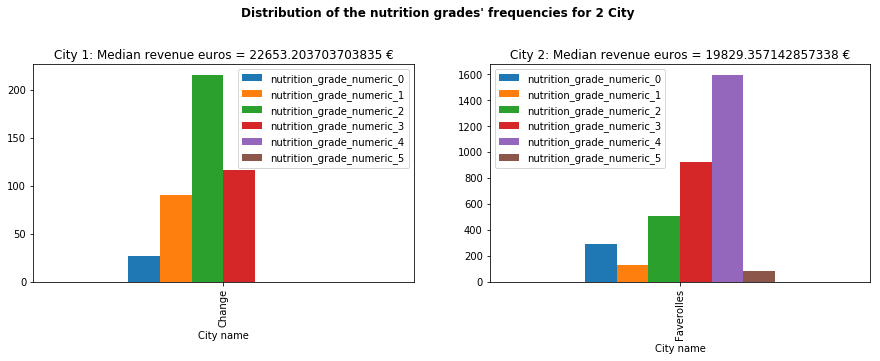

Mean: 
City name
Change        1.940000
Faverolles    3.035714
Name: nutrition_grade_numeric, dtype: float64
Median: 
City name
Change        2.0
Faverolles    3.0
Name: nutrition_grade_numeric, dtype: float64


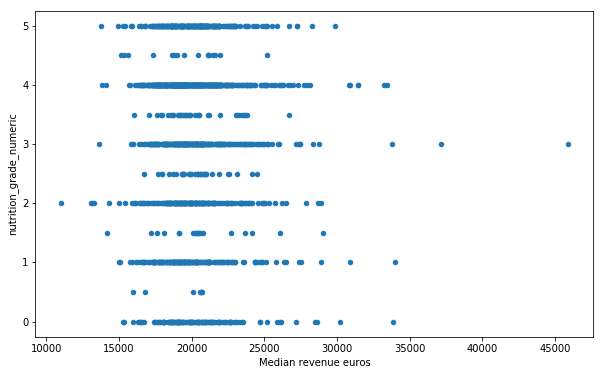

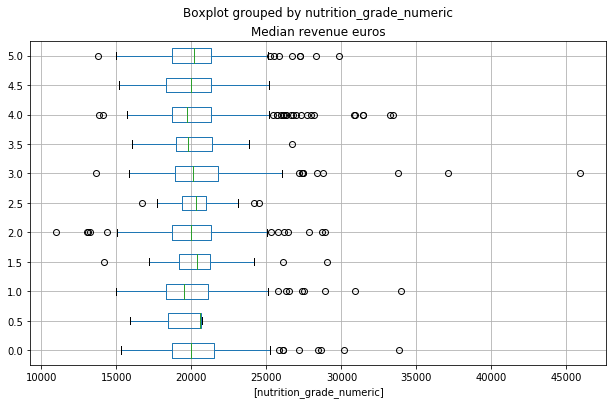

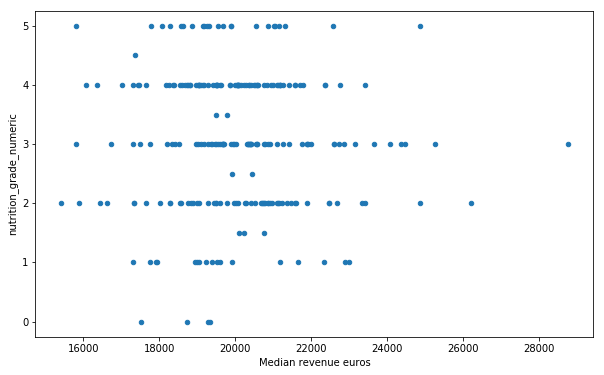

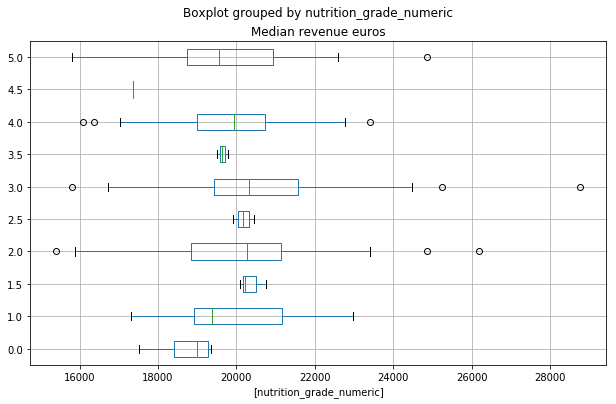

In [262]:
analyse_for_area('City name', 'City', 'Median revenue euros', 10)

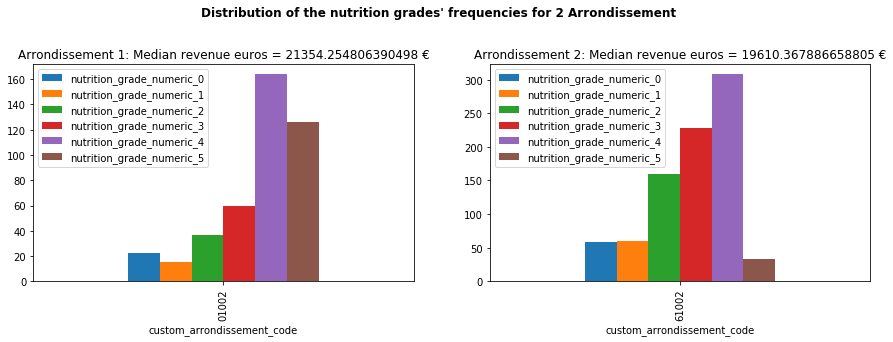

Mean: 
custom_arrondissement_code
01002    3.667453
61002    2.903188
Name: nutrition_grade_numeric, dtype: float64
Median: 
custom_arrondissement_code
07003    2.0
80003    3.0
Name: nutrition_grade_numeric, dtype: float64


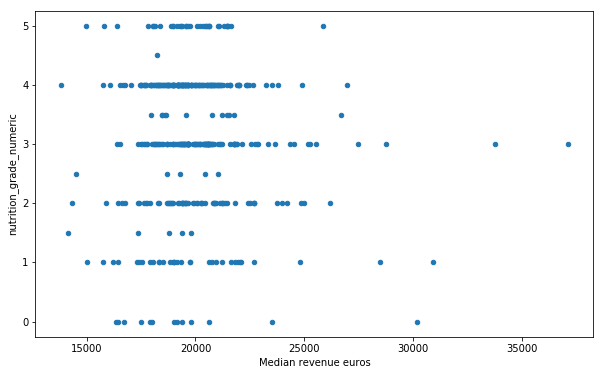

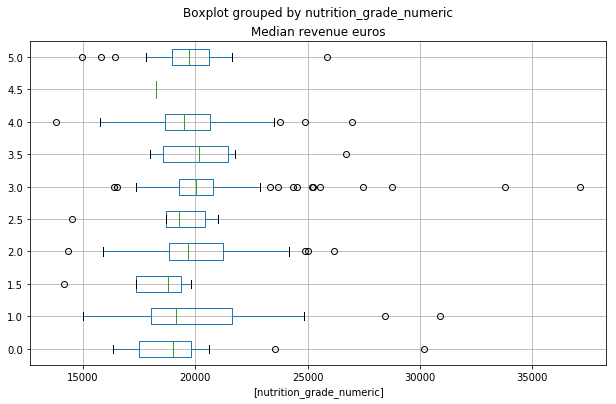

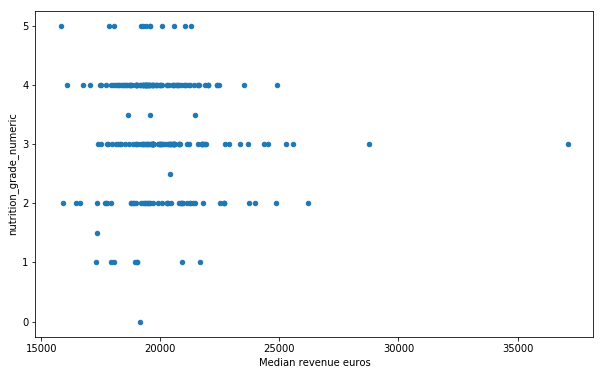

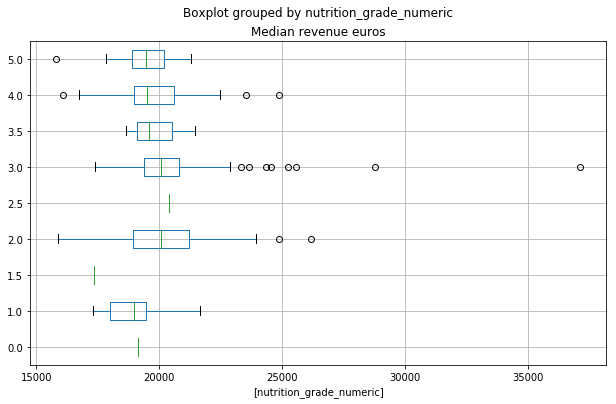

In [19]:
analyse_for_area('custom_arrondissement_code', 'Arrondissement', 'Median revenue euros', 10)

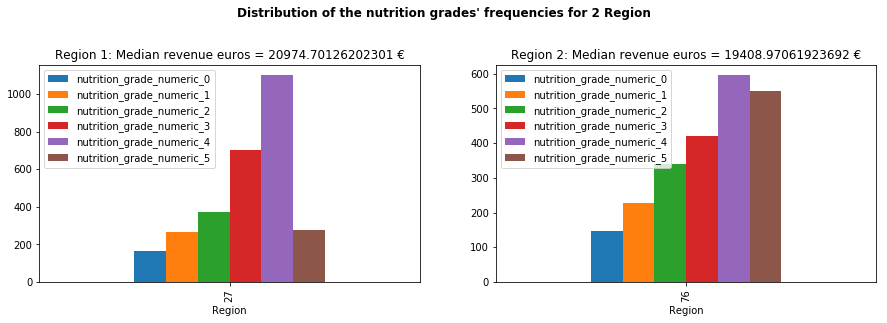

Mean: 
Region
27    3.092708
76    3.202282
Name: nutrition_grade_numeric, dtype: float64
Median: 
Region
27    3.0
76    4.0
Name: nutrition_grade_numeric, dtype: float64


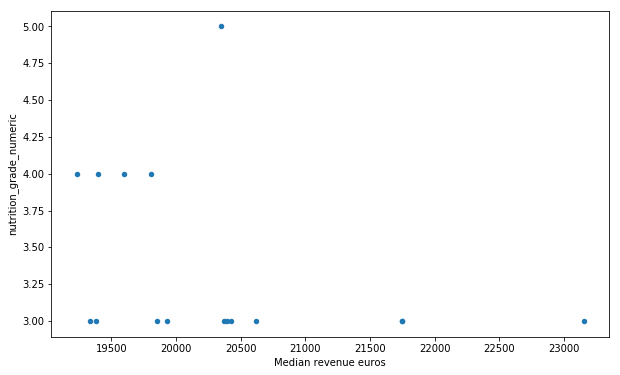

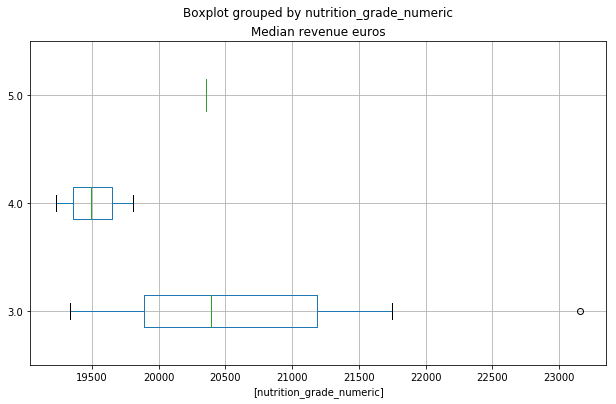

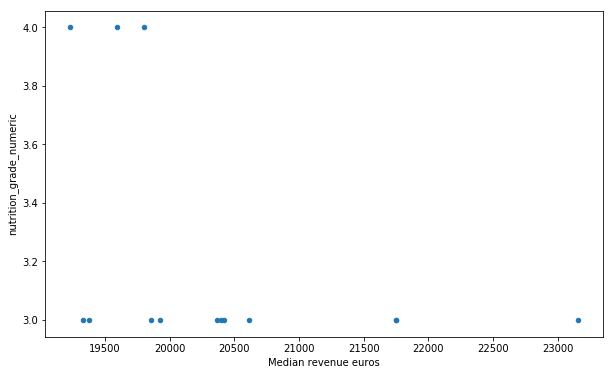

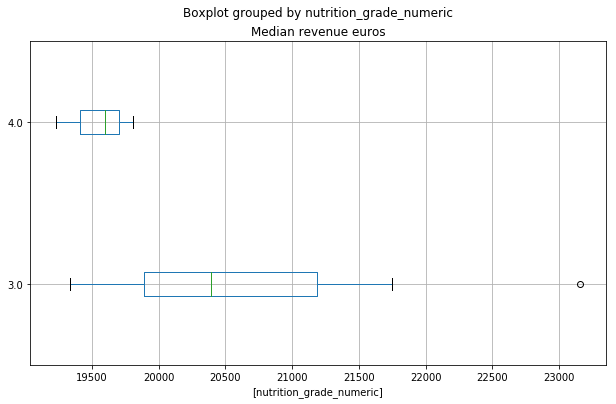

In [20]:
analyse_for_area('Region', 'Region', 'Median revenue euros', 10)

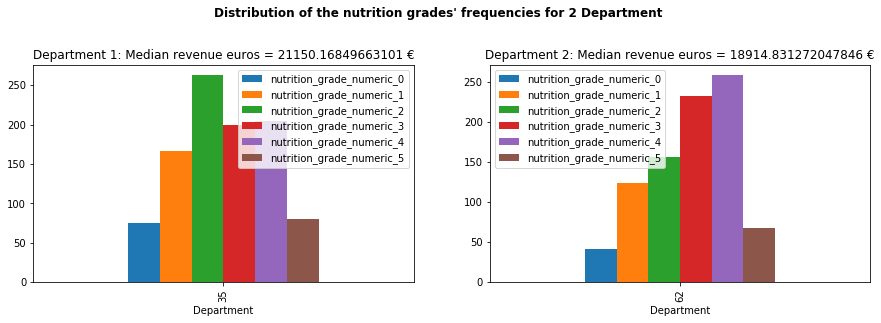

Mean: 
Department
35    2.536906
62    2.850170
Name: nutrition_grade_numeric, dtype: float64
Median: 
Department
35    2.0
72    3.0
Name: nutrition_grade_numeric, dtype: float64


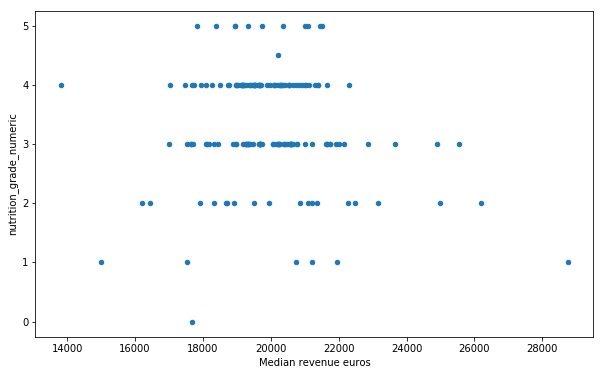

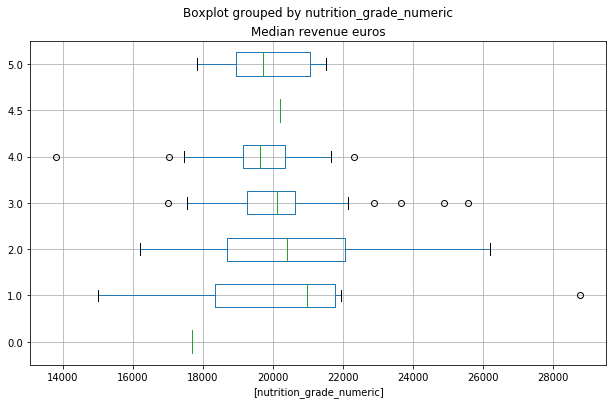

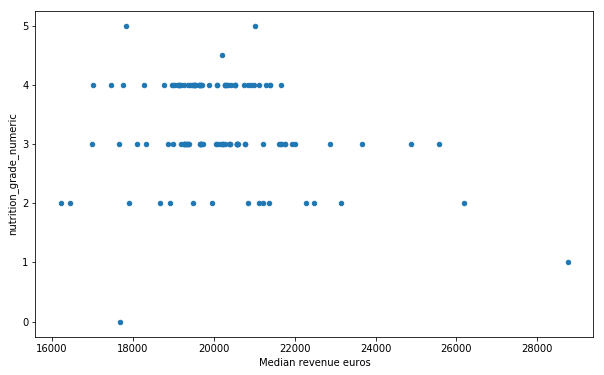

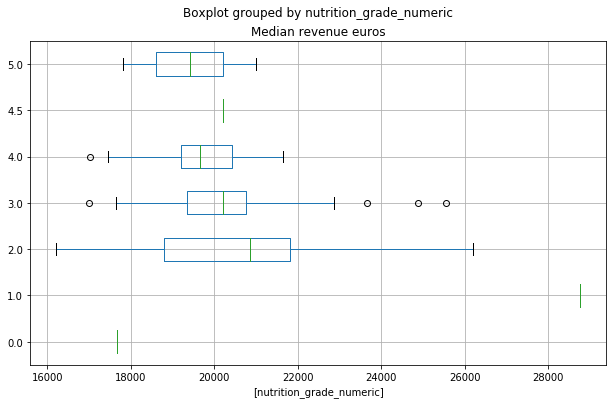

In [271]:
analyse_for_area('Department', 'Department', 'Median revenue euros', 10)

# 5. Study of correlations

# Correlation between income and "quality" of the available products

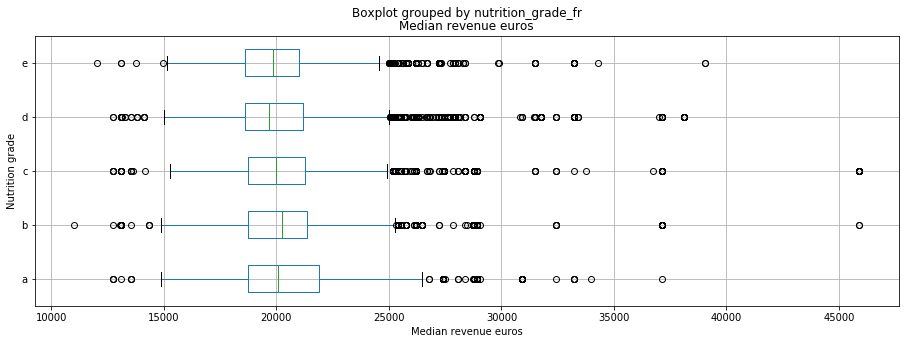

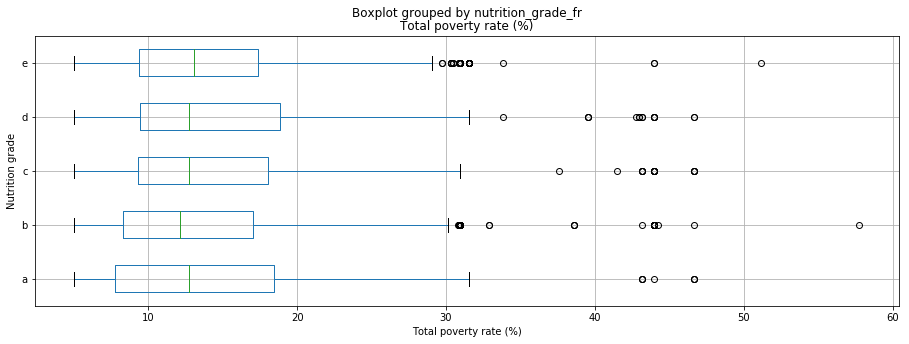

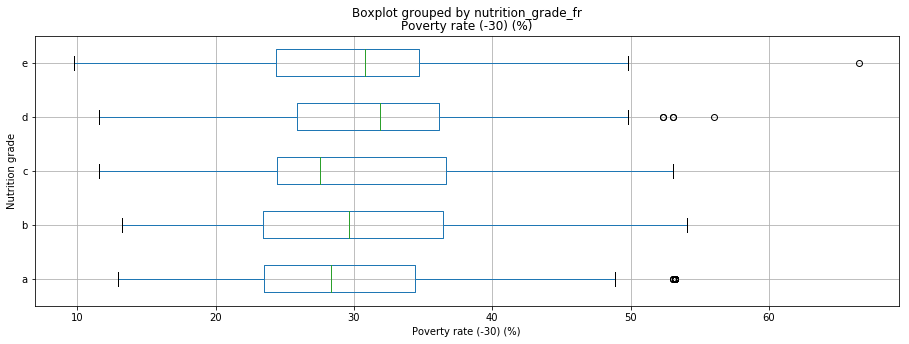

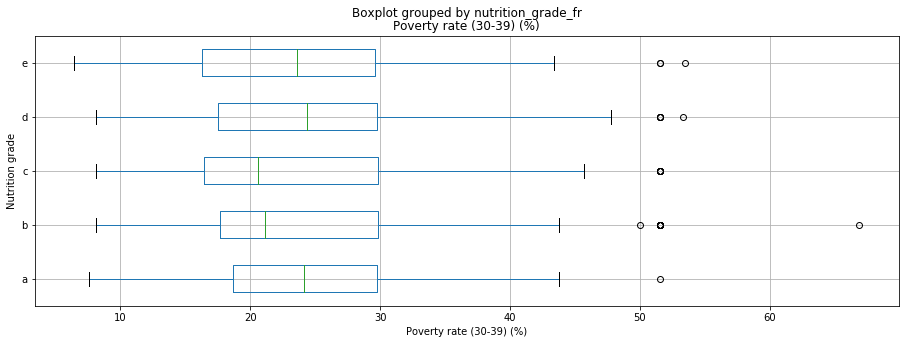

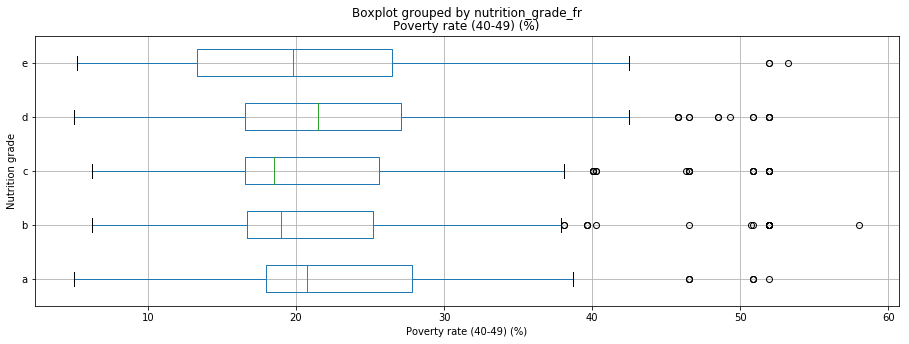

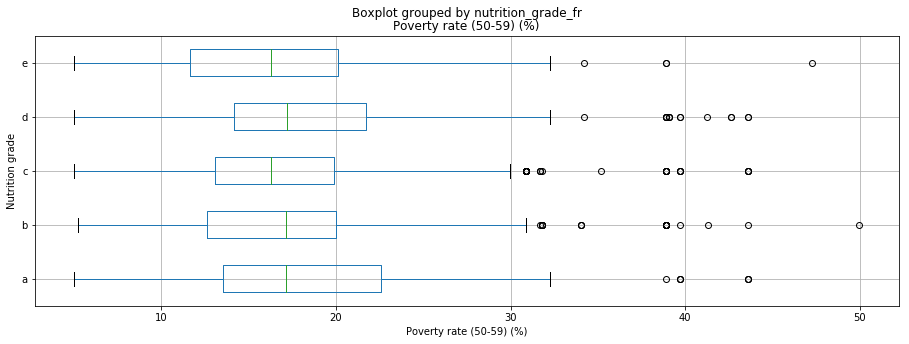

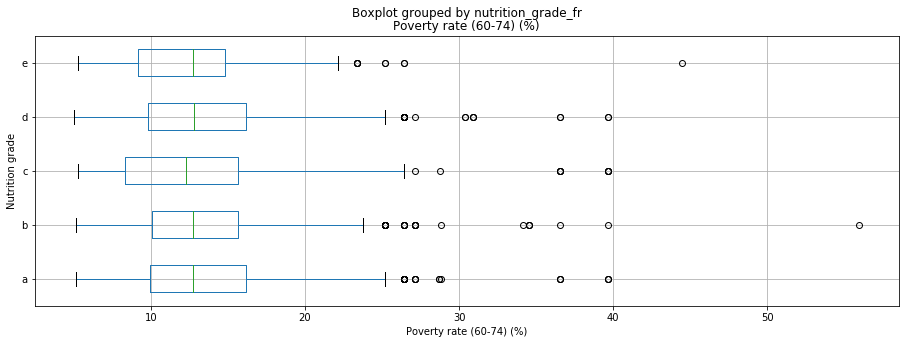

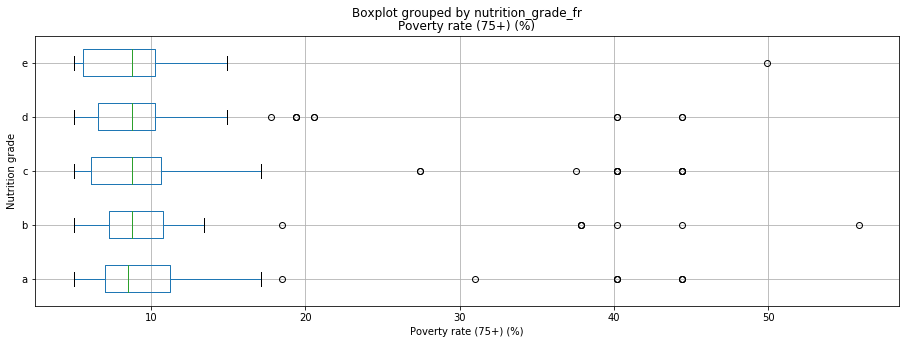

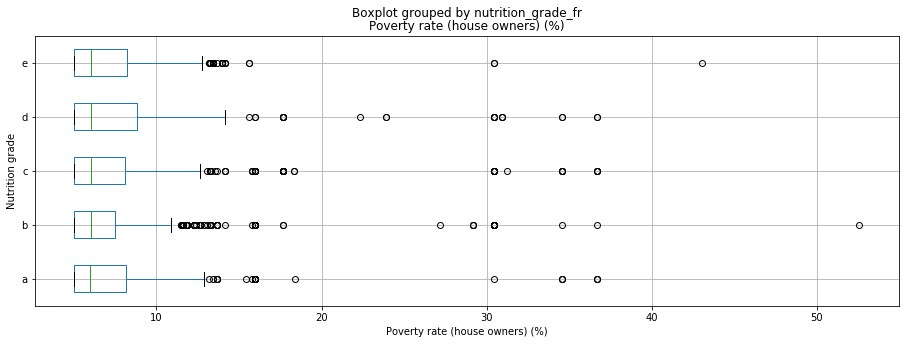

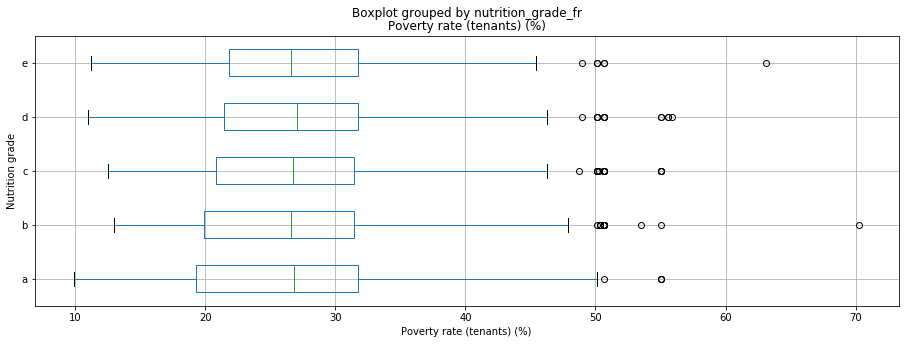

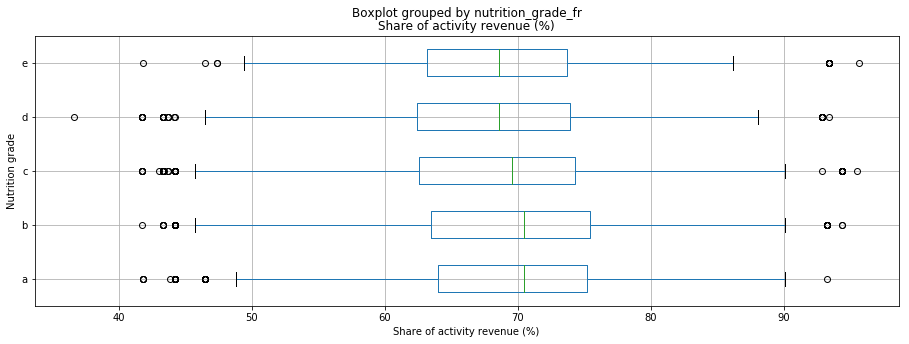

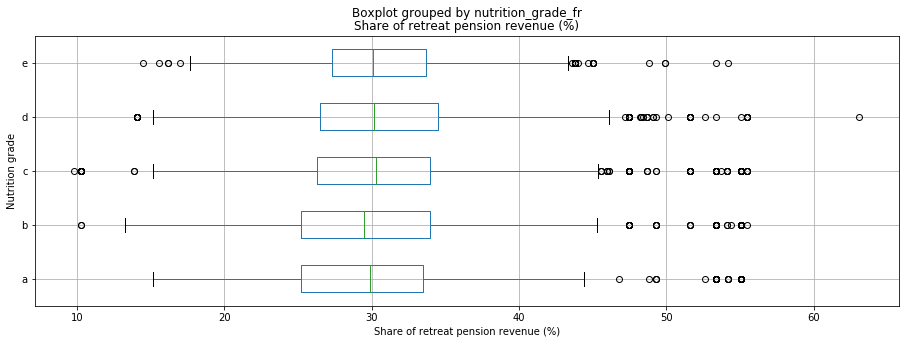

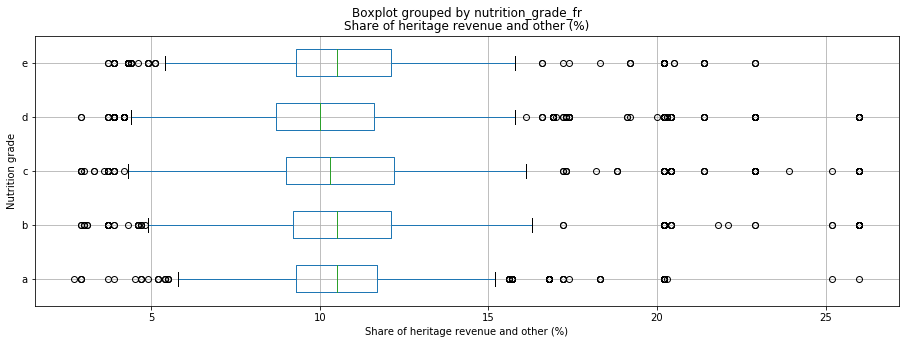

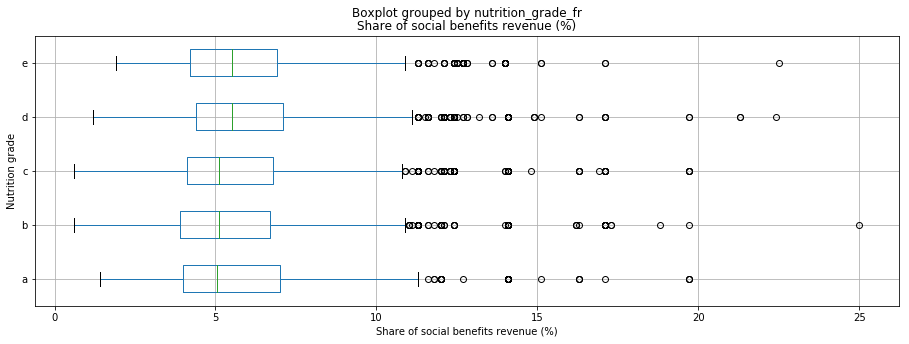

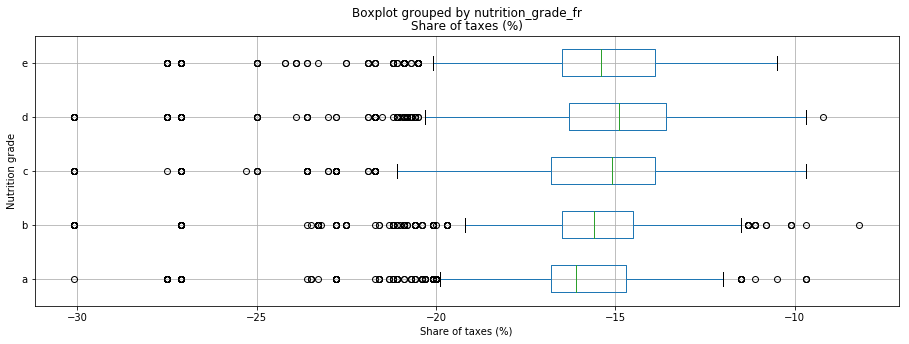

In [8]:
for column in ['Median revenue euros', 'Total poverty rate (%)',
       'Poverty rate (-30) (%)', 'Poverty rate (30-39) (%)',
       'Poverty rate (40-49) (%)', 'Poverty rate (50-59) (%)',
       'Poverty rate (60-74) (%)', 'Poverty rate (75+) (%)',
       'Poverty rate (house owners) (%)', 'Poverty rate (tenants) (%)',
       'Share of activity revenue (%)', 'Share of retreat pension revenue (%)',
       'Share of heritage revenue and other (%)',
       'Share of social benefits revenue (%)', 'Share of taxes (%)'
              ]:
    dataframe.boxplot(column=column, 
                  by='nutrition_grade_numeric', 
                  vert=False, figsize=(15, 5)
                 )
    plt.xlabel(column)#"Mean income of the purchase town (in €)")
    plt.ylabel("Nutrition grade")
    #plt.title("Distribution of the sold food items with regard to the median income of the purchase town.")
    plt.show()

In [9]:
dataframe.columns

Index(['Unnamed: 0', 'city_index', 'food_item_index',
       'city_tag_from_food_item', 'code', 'nutrition_grade_fr',
       'nutrition-score-fr_100g', 'nutrition-score-uk_100g', 'serving_size',
       'energy_100g', 'fat_100g', 'saturated-fat_100g', 'proteins_100g',
       'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'purchase_places',
       'stores', 'countries', 'countries_tags', 'City name',
       'Household inhabitants', 'Median revenue euros',
       'Total poverty rate (%)', 'Poverty rate (-30) (%)',
       'Poverty rate (30-39) (%)', 'Poverty rate (40-49) (%)',
       'Poverty rate (50-59) (%)', 'Poverty rate (60-74) (%)',
       'Poverty rate (75+) (%)', 'Poverty rate (house owners) (%)',
       'Poverty rate (tenants) (%)', 'Share of activity revenue (%)',
       'Share of retreat pension revenue (%)',
       'Share of heritage revenue and other (%)',
       'Share of social benefits revenue (%)', 'Share of taxes (%)',
       'nutrition_grade_numeric'],
      dtype='o

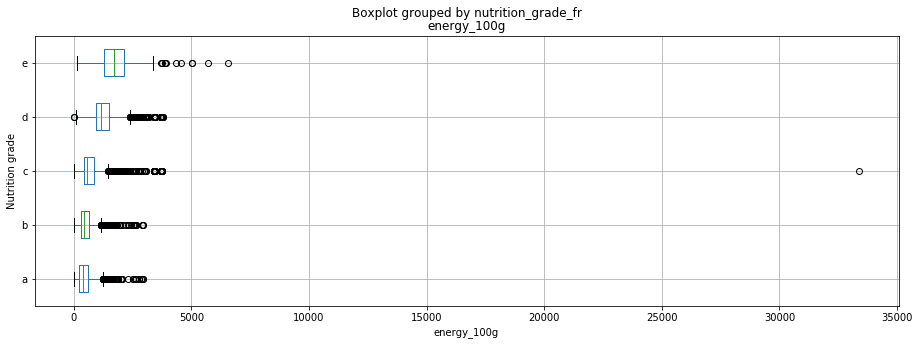

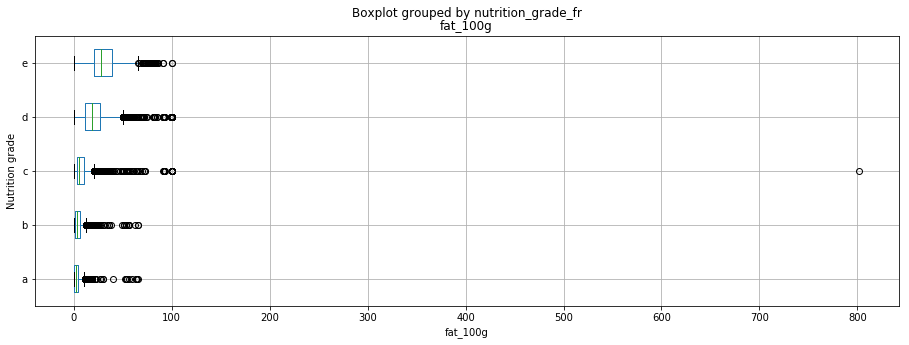

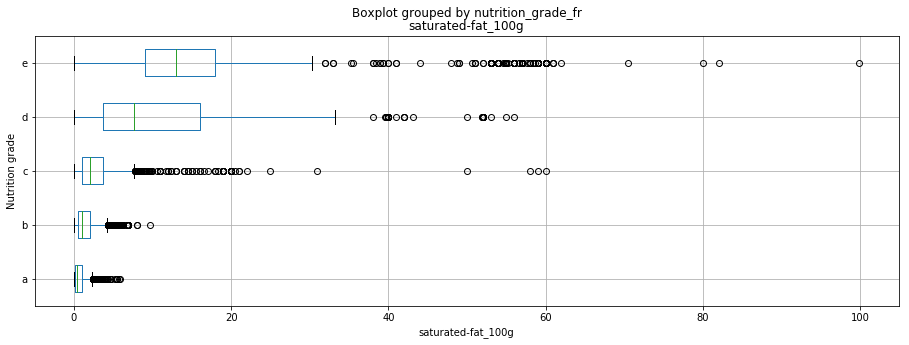

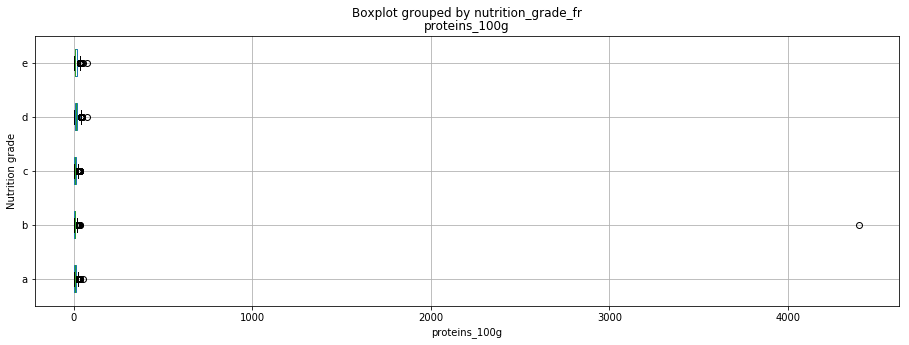

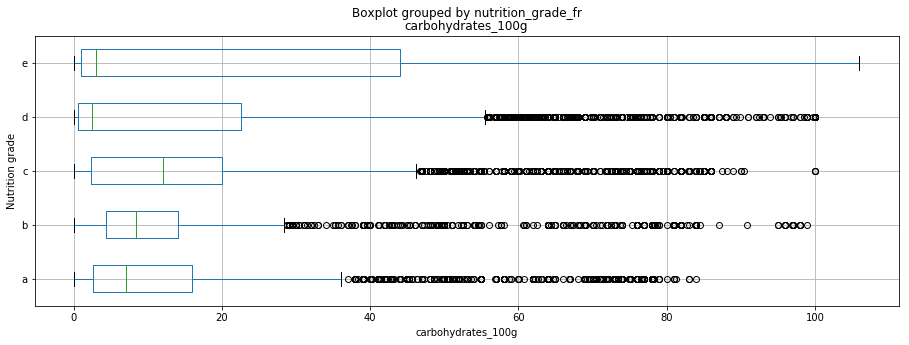

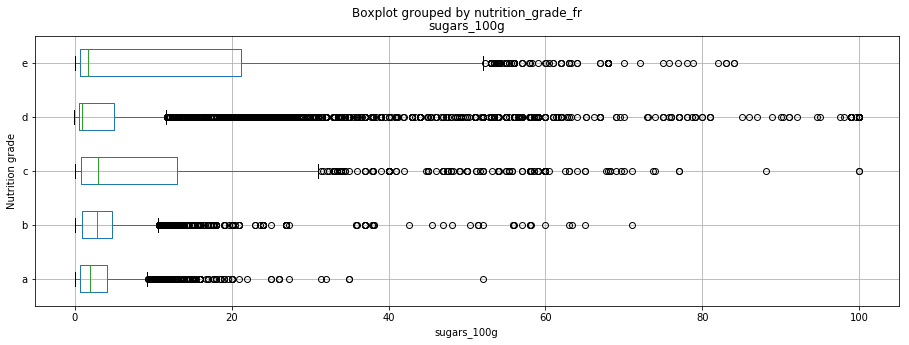

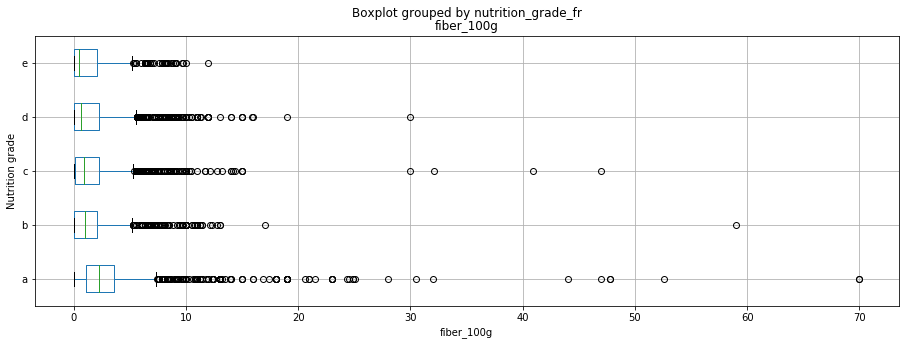

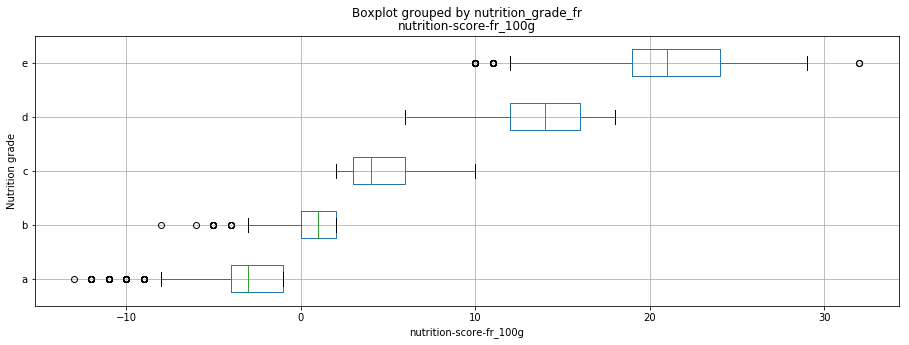

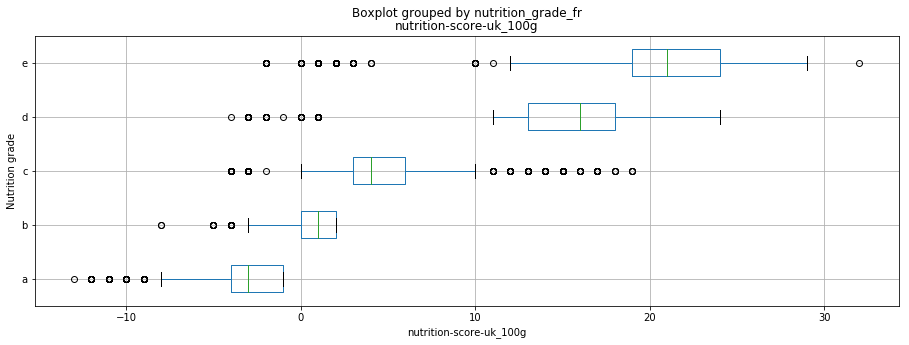

In [10]:
for food_column in ['energy_100g',
       'fat_100g', 'saturated-fat_100g', 'proteins_100g', 'carbohydrates_100g',
       'sugars_100g', 'fiber_100g', 'nutrition-score-fr_100g', 'nutrition-score-uk_100g']:
    dataframe.boxplot(column=food_column, 
                  by='nutrition_grade_fr', 
                  vert=False, figsize=(15, 5)
                 )
    plt.xlabel(food_column)#"Mean income of the purchase town (in €)")
    plt.ylabel("Nutrition grade")
    #plt.title("Distribution of the sold food items with regard to the median income of the purchase town.")
    plt.show()

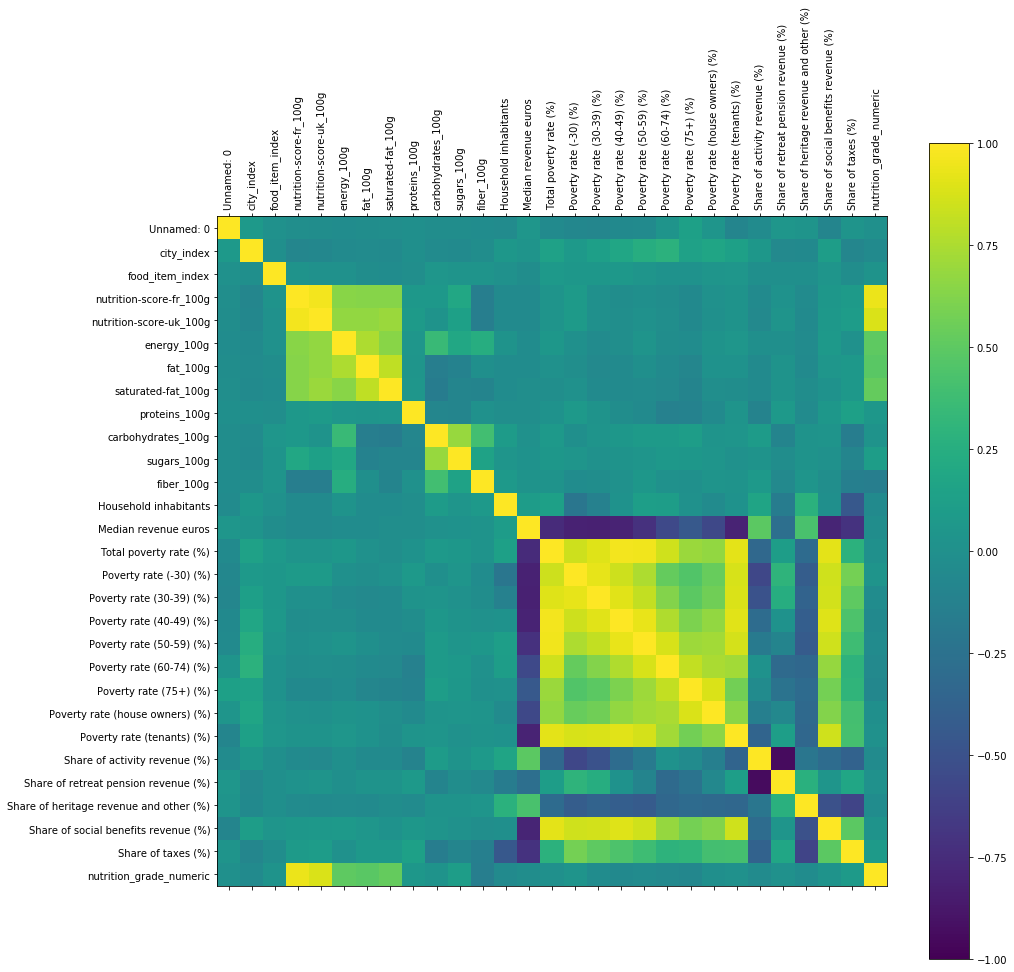

In [11]:
correlations = dataframe.corr()
names = list(correlations.columns)
# plot correlation matrix
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0, len(names), 1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(names)
ax.set_yticklabels(names)
plt.xticks(rotation='vertical')
plt.show()

We see that there is no correlation between the nutrition grade or any other food-related feature, and the income-related features.

There is however a small (~0.6) positive correlation between the nutrition grade and the amount of energy, fat, and saturated in a food item.

Le score est calculé par un système de points, le score le plus faible étant le meilleur.

- éléments défavorables au score : apport calorique pour 100 grammes, teneur en sucre, en graisses saturées et en sel.

- éléments favorables au score : teneur en fruits, légumes, légumineuses et oléagineux, teneur en fibres, et enfin teneur en protéines.

In [12]:
dataframe.head()

,Unnamed: 0,city_index,food_item_index,city_tag_from_food_item,code,nutrition_grade_fr,nutrition-score-fr_100g,nutrition-score-uk_100g,serving_size,energy_100g,...,Poverty rate (60-74) (%),Poverty rate (75+) (%),Poverty rate (house owners) (%),Poverty rate (tenants) (%),Share of activity revenue (%),Share of retreat pension revenue (%),Share of heritage revenue and other (%),Share of social benefits revenue (%),Share of taxes (%),nutrition_grade_numeric
0,0,30,359180,belley-ain-france,3307906000064,d,14.0,19.0,150 g,1243.0,...,16.949153,NaN,6.205567,29.609475,65.9,31.2,11.1,7.1,-15.3,4
1,1,30,359153,belley-ain-france,3307902060086,d,15.0,20.0,NaN,1402.0,...,16.949153,NaN,6.205567,29.609475,65.9,31.2,11.1,7.1,-15.3,4
2,2,30,359177,belley-ain-france,3307905810084,d,15.0,20.0,NaN,1435.0,...,16.949153,NaN,6.205567,29.609475,65.9,31.2,11.1,7.1,-15.3,4
3,3,30,359157,belley-ain-france,3307904400125,d,14.0,19.0,NaN,1238.0,...,16.949153,NaN,6.205567,29.609475,65.9,31.2,11.1,7.1,-15.3,4
4,4,30,359155,belley-ain-france,3307903690121,d,15.0,20.0,NaN,1435.0,...,16.949153,NaN,6.205567,29.609475,65.9,31.2,11.1,7.1,-15.3,4


In [13]:
nutri_score = ((dataframe['energy_100g'] / dataframe['energy_100g'].std()) 
+ (dataframe['fat_100g'] / dataframe['fat_100g'].std()) 
+ (dataframe['saturated-fat_100g'] / dataframe['saturated-fat_100g'].std())
+ (dataframe['sugars_100g'] / dataframe['sugars_100g'].std())) 
nutri_score = nutri_score.divide((dataframe['fiber_100g'] / dataframe['fiber_100g'].std()) +
                                 (dataframe['proteins_100g'] / dataframe['proteins_100g'].std()))
nutri_score = nutri_score.replace([np.inf, -np.inf], np.nan)

In [14]:
nutri_score_noNa = dataframe['energy_100g'].fillna(0) / dataframe['energy_100g'].fillna(0).std() 
+ dataframe['fat_100g'].fillna(0) / dataframe['fat_100g'].fillna(0).std()
+ dataframe['saturated-fat_100g'].fillna(0) / dataframe['saturated-fat_100g'].fillna(0).std()
+ dataframe['sugars_100g'].fillna(0) / dataframe['sugars_100g'].fillna(0).std()
nutri_score_noNa = nutri_score_noNa.replace([np.inf, -np.inf], np.nan)

In [15]:
pearson_coeff = dataframe['Median revenue euros'].corr(nutri_score)
print('The Pearson coefficient between nutrition score and median revenue is: {pearson:.3f}'
      .format(pearson=pearson_coeff))

The Pearson coefficient between nutrition score and median revenue is: 0.004


In [16]:
pearson_coeff = dataframe['Total poverty rate (%)'].corr(nutri_score)
print('The Pearson coefficient between nutrition score and total poverty rate is: {pearson:.3f}'
      .format(pearson=pearson_coeff))

The Pearson coefficient between nutrition score and total poverty rate is: 0.010


In [17]:
pearson_coeff = dataframe['Poverty rate (-30) (%)'].corr(nutri_score)
print('The Pearson coefficient between nutrition score and poverty rate for people under 30 is: {pearson:.3f}'
      .format(pearson=pearson_coeff))

The Pearson coefficient between nutrition score and poverty rate for people under 30 is: 0.011


In [18]:
pearson_coeff = dataframe['Poverty rate (30-39) (%)'].corr(nutri_score)
print('The Pearson coefficient between nutrition score and poverty rate for people between 30 and 39 is: {pearson:.3f}'
      .format(pearson=pearson_coeff))

The Pearson coefficient between nutrition score and poverty rate for people between 30 and 39 is: 0.004


In [19]:
pearson_coeff = dataframe['Poverty rate (40-49) (%)'].corr(nutri_score)
print('The Pearson coefficient between nutrition score and poverty rate for people between 40 and 49 is: {pearson:.3f}'
      .format(pearson=pearson_coeff))

The Pearson coefficient between nutrition score and poverty rate for people between 40 and 49 is: 0.010


In [20]:
pearson_coeff = dataframe['Poverty rate (50-59) (%)'].corr(nutri_score)
print('The Pearson coefficient between nutrition score and poverty rate for people between 50 and 59 is: {pearson:.3f}'
      .format(pearson=pearson_coeff))

The Pearson coefficient between nutrition score and poverty rate for people between 50 and 59 is: 0.020


In [21]:
pearson_coeff = dataframe['Poverty rate (60-74) (%)'].corr(nutri_score)
print('The Pearson coefficient between nutrition score and poverty rate for people between 60 and 74 is: {pearson:.3f}'
      .format(pearson=pearson_coeff))

The Pearson coefficient between nutrition score and poverty rate for people between 60 and 74 is: 0.013


In [22]:
pearson_coeff = dataframe['Poverty rate (75+) (%)'].corr(nutri_score)
print('The Pearson coefficient between nutrition score and poverty rate for people older than 75 is: {pearson:.3f}'
      .format(pearson=pearson_coeff))

The Pearson coefficient between nutrition score and poverty rate for people older than 75 is: 0.013


In [23]:
pearson_coeff = dataframe['Share of social benefits revenue (%)'].corr(nutri_score)
print('The Pearson coefficient between nutrition score and the share of social benefits in the income is: {pearson:.3f}'
      .format(pearson=pearson_coeff))

The Pearson coefficient between nutrition score and the share of social benefits in the income is: 0.010


In [24]:
dataframe['nutri_score'] = nutri_score_noNa

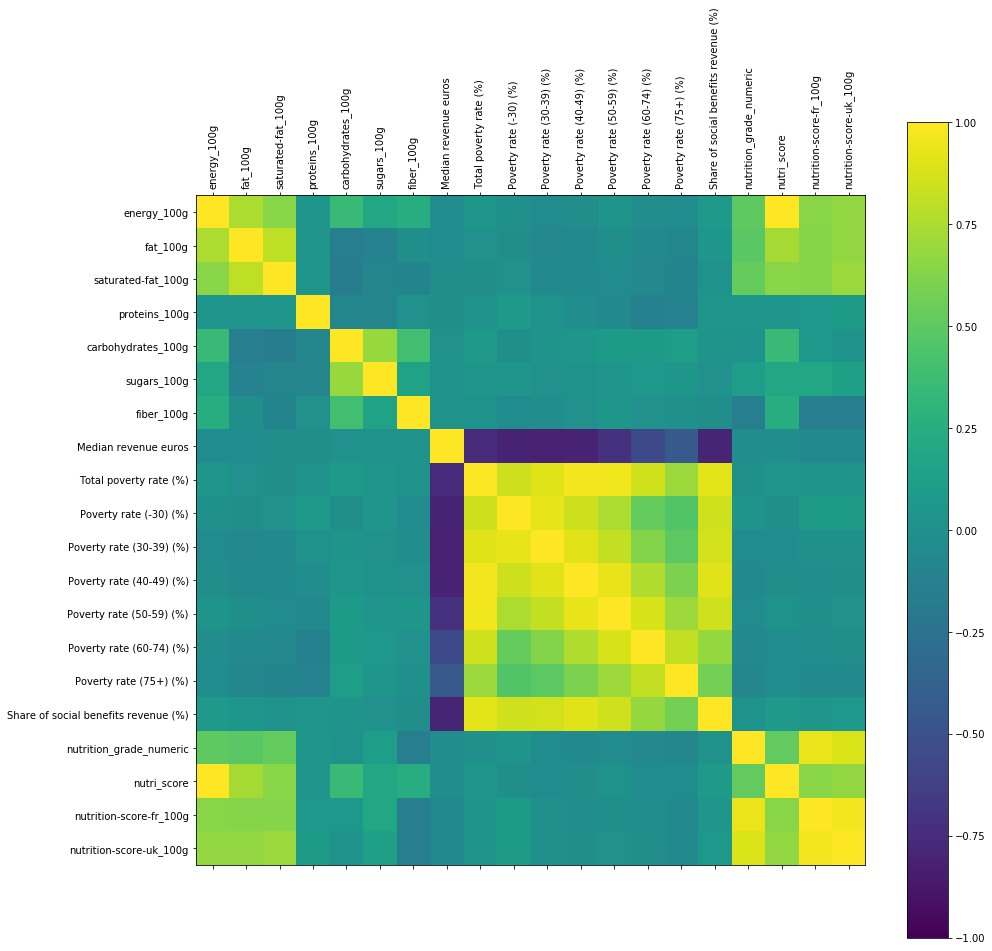

In [25]:
correlations_2 = dataframe[['energy_100g',
                            'fat_100g', 'saturated-fat_100g', 'proteins_100g', 'carbohydrates_100g',
                            'sugars_100g', 'fiber_100g', 'Median revenue euros', 'Total poverty rate (%)',
                            'Poverty rate (-30) (%)', 'Poverty rate (30-39) (%)',
                            'Poverty rate (40-49) (%)', 'Poverty rate (50-59) (%)',
                            'Poverty rate (60-74) (%)', 'Poverty rate (75+) (%)',
                            'Share of social benefits revenue (%)', 'nutrition_grade_numeric', 'nutri_score', 
                            'nutrition-score-fr_100g', 'nutrition-score-uk_100g']].corr()
names = list(correlations_2.columns)
# plot correlation matrix
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111)
cax = ax.matshow(correlations_2, vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0, len(names), 1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(names)
ax.set_yticklabels(names)
plt.xticks(rotation='vertical')
plt.show()

# Correlation between stores and quality of the products

In [26]:
store_dataframe = pd.read_csv('../data/processed/clean_food_and_stores.csv')

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [27]:
nutrition_store_df = store_dataframe[['store_name', 'nutrition_grade_numeric', 
                                      'nutrition-score-fr_100g', 'nutrition-score-uk_100g']]
nutrition_store_df = nutrition_store_df[nutrition_store_df['nutrition_grade_numeric'] > 0]
nutrition_per_store = nutrition_store_df.groupby('store_name').agg(['mean', 'count', 'median'])
nutrition_per_store.describe()

nutrition_grade_numeric                           \
                         mean        count      median   
count              439.000000   439.000000  439.000000   
mean                 3.119361    54.943052    3.121868   
std                  1.166083   278.506239    1.227752   
min                  1.000000     1.000000    1.000000   
25%                  2.000000     1.000000    2.000000   
50%                  3.026316     2.000000    3.000000   
75%                  4.000000     5.000000    4.000000   
max                  5.000000  3456.000000    5.000000   

      nutrition-score-fr_100g                           \
                         mean        count      median   
count              439.000000   439.000000  439.000000   
mean                 8.303977    54.943052    8.053531   
std                  7.847624   278.506239    8.180050   
min                -10.000000     1.000000  -10.000000   
25%                  2.000000     1.000000    1.000000   
50%                  7.500000     2.000000    6.000000   
75%                 14.000000     5.000000   14.000000   
max                 27.000000  3456.000000   27.000000   

      nutrition-score-uk_100g                           
                         mean        count      median  
count              439.000000   439.000000  439.000000  
mean                 8.599316    54.943052    8.263098  
std                  8.409214   278.506239    8.816801  
min                -10.000000     1.000000  -10.000000  
25%                  2.000000     1.000000    1.000000  
50%                  7.500000     2.000000    5.000000  
75%                 16.000000     5.000000   16.000000  
max                 27.000000  3456.000000   27.000000

In [28]:
nutrition_per_store.columns = ['_'.join(col).strip().strip('_') for col in nutrition_per_store.columns.values]

In [29]:
nutrition_per_store = nutrition_per_store[nutrition_per_store["nutrition_grade_numeric_count"] > 100]
nutrition_per_store.describe()

,nutrition_grade_numeric_mean,nutrition_grade_numeric_count,nutrition_grade_numeric_median,nutrition-score-fr_100g_mean,nutrition-score-fr_100g_count,nutrition-score-fr_100g_median,nutrition-score-uk_100g_mean,nutrition-score-uk_100g_count,nutrition-score-uk_100g_median
count,25.000000,25.000000,25.0,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000
mean,3.124525,871.840000,3.2,8.051683,871.840000,7.220000,8.367413,871.840000,6.900000
std,0.253324,822.305837,0.5,1.634721,822.305837,3.109394,1.903564,822.305837,3.622844
min,2.526682,111.000000,2.0,4.354839,111.000000,2.000000,4.415313,111.000000,2.000000
25%,3.048739,270.000000,3.0,7.344156,270.000000,5.000000,7.500000,270.000000,5.000000
50%,3.110390,600.000000,3.0,7.996817,600.000000,6.000000,8.430449,600.000000,5.000000
75%,3.249794,1263.000000,3.0,8.809053,1263.000000,10.000000,9.402439,1263.000000,10.000000
max,3.593651,3456.000000,4.0,11.000000,3456.000000,13.000000,11.758730,3456.000000,14.000000


In [30]:
nutrition_per_store.reset_index()
nutrition_per_store

,nutrition_grade_numeric_mean,nutrition_grade_numeric_count,nutrition_grade_numeric_median,nutrition-score-fr_100g_mean,nutrition-score-fr_100g_count,nutrition-score-fr_100g_median,nutrition-score-uk_100g_mean,nutrition-score-uk_100g_count,nutrition-score-uk_100g_median
store_name,,,,,,,,,
aldi,3.095491,377,3.0,7.729443,377,5.0,8.519894,377,5.0
auchan,3.048739,1785,3.0,7.371429,1785,5.0,7.809524,1785,5.0
banque alimentaire,2.541219,279,2.0,4.354839,279,2.0,4.455197,279,2.0
carrefour,3.108507,3456,3.0,7.996817,3456,6.0,8.017650,3456,5.0
carrefour city,3.207447,188,3.0,8.382979,188,6.0,7.792553,188,5.0
carrefour market,3.082816,966,3.0,7.789855,966,6.0,7.979296,966,5.0
casino,2.894393,1070,3.0,6.639252,1070,4.0,6.368224,1070,3.0
cora,3.181536,1289,3.0,8.356866,1289,8.0,8.678821,1289,7.0
dia,3.425061,407,4.0,10.228501,407,12.0,11.031941,407,13.0


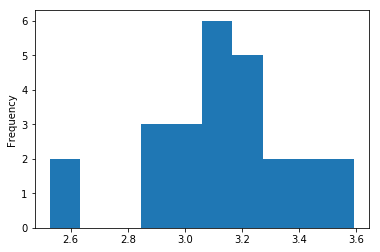

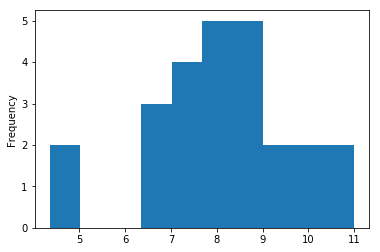

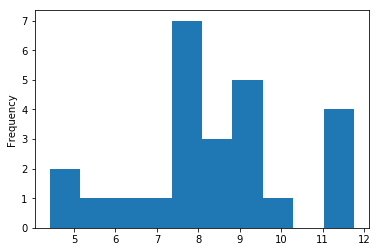

In [31]:
nutrition_per_store['nutrition_grade_numeric_mean'].plot.hist()
plt.show()

nutrition_per_store['nutrition-score-fr_100g_mean'].plot.hist()
plt.show()

nutrition_per_store['nutrition-score-uk_100g_mean'].plot.hist()
plt.show()

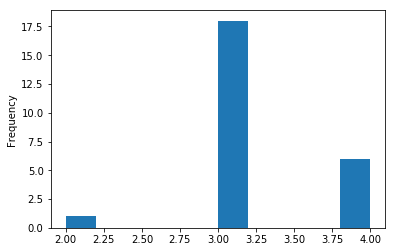

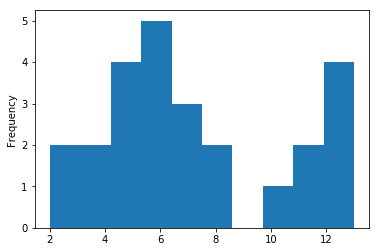

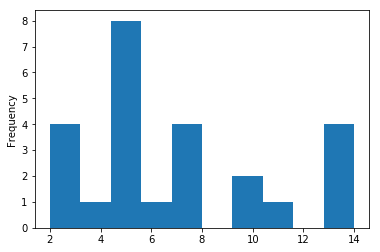

In [32]:
nutrition_per_store['nutrition_grade_numeric_median'].plot.hist()
plt.show()

nutrition_per_store['nutrition-score-fr_100g_median'].plot.hist()
plt.show()

nutrition_per_store['nutrition-score-uk_100g_median'].plot.hist()
plt.show()

We see that there is no significant difference between the discounters and the main stores. Also, stores for which we have enough data have roughly the same mean and median.

In [33]:
nutrition_per_store[nutrition_per_store['nutrition-score-fr_100g_median'] > 9]

,nutrition_grade_numeric_mean,nutrition_grade_numeric_count,nutrition_grade_numeric_median,nutrition-score-fr_100g_mean,nutrition-score-fr_100g_count,nutrition-score-fr_100g_median,nutrition-score-uk_100g_mean,nutrition-score-uk_100g_count,nutrition-score-uk_100g_median
store_name,,,,,,,,,
dia,3.425061,407,4.0,10.228501,407,12.0,11.031941,407,13.0
grand frais,3.521978,182,4.0,10.763736,182,12.0,11.049451,182,13.0
leader price,3.296748,984,4.0,9.428862,984,11.0,9.402439,984,10.0
magasins u,3.249794,2430,3.0,8.809053,2430,10.0,9.515226,2430,10.0
netto,3.593651,315,4.0,11.000000,315,13.0,11.758730,315,13.0
simply market,3.300000,270,4.0,9.051852,270,11.0,9.862963,270,11.0
u express,3.408537,164,4.0,10.201220,164,12.0,11.390244,164,14.0


In [34]:
nutrition_per_store[nutrition_per_store['nutrition-score-uk_100g_median'] >= 9]

,nutrition_grade_numeric_mean,nutrition_grade_numeric_count,nutrition_grade_numeric_median,nutrition-score-fr_100g_mean,nutrition-score-fr_100g_count,nutrition-score-fr_100g_median,nutrition-score-uk_100g_mean,nutrition-score-uk_100g_count,nutrition-score-uk_100g_median
store_name,,,,,,,,,
dia,3.425061,407,4.0,10.228501,407,12.0,11.031941,407,13.0
grand frais,3.521978,182,4.0,10.763736,182,12.0,11.049451,182,13.0
leader price,3.296748,984,4.0,9.428862,984,11.0,9.402439,984,10.0
magasins u,3.249794,2430,3.0,8.809053,2430,10.0,9.515226,2430,10.0
netto,3.593651,315,4.0,11.000000,315,13.0,11.758730,315,13.0
simply market,3.300000,270,4.0,9.051852,270,11.0,9.862963,270,11.0
u express,3.408537,164,4.0,10.201220,164,12.0,11.390244,164,14.0


# Visualization

In [36]:
map_df = pd.read_csv("../data/processed/clean_food_cities_arrond.csv")

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (5,39,40,42,45) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [37]:
df_revenue = map_df[['custom_arrondissement_code', 'Median revenue euros']].dropna().groupby('custom_arrondissement_code').median().reset_index()

In [38]:
df_revenue.describe()

,Median revenue euros
count,439.000000
mean,19960.111904
std,2406.321043
min,13812.413793
25%,18699.555556
50%,19646.666667
75%,20819.236111
max,37125.625000


In [39]:
map_revenue = folium.Map(location=[46.9, 2.7], tiles='cartodbpositron', zoom_start=6)
map_revenue

In [40]:
scale = np.linspace(np.min(df_revenue['Median revenue euros']), np.max(df_revenue['Median revenue euros']), 6)
scale

array([13812.4137931 , 18475.05603448, 23137.69827586, 27800.34051724,
       32462.98275862, 37125.625     ])

In [41]:
map_revenue = folium.Map(location=[46.5, 2.3], tiles='cartodbpositron', zoom_start=6)

In [43]:
# geojson: https://github.com/gregoiredavid/france-geojson
arr_borders = json.load(open("../data/raw/arrondissements.geojson"))

In [44]:
# This does work
map_revenue.choropleth(geo_data=arr_borders, 
                   data=df_revenue, 
                   columns=['custom_arrondissement_code', 'Median revenue euros'],
                   key_on='feature.properties.code',
                   legend_name='Median revenue in euros',
                   threshold_scale=list(scale),
                   fill_color='OrRd',fill_opacity=0.7, line_opacity=0.2,
                      )

map_revenue.save("../data/processed/map_revenue.html")

In [46]:
display(HTML("<a href='../data/processed/map_revenue.html' target='_blank'>Median revenue</a>"))

In [47]:
df_nutrition_geo = map_df[
    ['custom_arrondissement_code', 'nutrition_grade_numeric', 'nutrition-score-fr_100g', 'nutrition-score-uk_100g']
].dropna().groupby('custom_arrondissement_code').median().reset_index()

In [48]:
df_nutrition_geo.describe()

,nutrition_grade_numeric,nutrition-score-fr_100g,nutrition-score-uk_100g
count,434.000000,434.00000,434.000000
mean,3.297235,8.89977,9.478111
std,1.059605,7.06476,8.009455
min,1.000000,-10.00000,-10.000000
25%,3.000000,3.00000,3.000000
50%,3.250000,10.00000,9.750000
75%,4.000000,14.00000,17.000000
max,5.000000,26.00000,26.000000


In [49]:
for column in ['nutrition_grade_numeric', 'nutrition-score-fr_100g', 'nutrition-score-uk_100g']:
    map_nutrition = folium.Map(location=[46.5, 2.3], tiles='cartodbpositron', zoom_start=6)
    scale = np.linspace(np.min(df_nutrition_geo[column]), np.max(df_nutrition_geo[column]), 6)
    map_nutrition.choropleth(geo_data=arr_borders, 
                           data=df_nutrition_geo, 
                           columns=['custom_arrondissement_code', column],
                           key_on='feature.properties.code',
                           legend_name=column,
                           threshold_scale=list(scale),
                           fill_color='OrRd',fill_opacity=0.7, line_opacity=0.2,
                      )

    map_nutrition.save("../data/processed/map_{}.html".format(column))
    display(HTML("<a href='../data/processed/map_{0}.html' target='_blank'>{0}</a>".format(column)))

In [50]:
df_nutrition_revenue_geo = map_df[
    ['custom_arrondissement_code', 'Median revenue euros', 'nutrition_grade_numeric', 
     'nutrition-score-fr_100g', 'nutrition-score-uk_100g']
].dropna().groupby('custom_arrondissement_code').agg({
    'Median revenue euros': ['mean', 'median'],
    'nutrition_grade_numeric': ['mean', 'median'],
    'nutrition-score-fr_100g': ['mean', 'median'],
    'nutrition-score-uk_100g': ['mean', 'median'],
}).reset_index()
df_nutrition_revenue_geo.columns = ['_'.join(col).strip().strip('_') for col in df_nutrition_revenue_geo.columns.values]
for measure in ['mean', 'median']:
    for column in ['nutrition_grade_numeric', 'nutrition-score-fr_100g', 'nutrition-score-uk_100g']:
        df_nutrition_revenue_geo[
            'comparison_revenue_{column}_{measure}'.format(column=column, measure=measure)
        ] = df_nutrition_revenue_geo[
            '{column}_{measure}'.format(column=column, measure=measure)
        ] / df_nutrition_revenue_geo['Median revenue euros_{measure}'.format(measure=measure)]
        map_nutrition = folium.Map(location=[46.5, 2.3], tiles='cartodbpositron', zoom_start=6)
        scale = np.linspace(
            np.min(df_nutrition_revenue_geo[
                'comparison_revenue_{column}_{measure}'.format(column=column, measure=measure)
            ]), 
            np.max(df_nutrition_revenue_geo[
                'comparison_revenue_{column}_{measure}'.format(column=column, measure=measure)
            ]), 6)
        map_nutrition.choropleth(geo_data=arr_borders, 
                               data=df_nutrition_revenue_geo, 
                               columns=['custom_arrondissement_code', 
                                        'comparison_revenue_{column}_{measure}'
                                        .format(column=column, measure=measure)],
                               key_on='feature.properties.code',
                               legend_name='comparison_revenue_{column}_{measure}'
                                 .format(column=column, measure=measure),
                               threshold_scale=list(scale),
                               fill_color='OrRd',fill_opacity=0.7, line_opacity=0.2,
                          )

        map_nutrition.save("../data/processed/map_{}.html".format(
            'comparison_revenue_{column}_{measure}'.format(column=column, measure=measure)
        ))
        display(HTML("<a href='../data/processed/map_{0}.html' target='_blank'>{0}</a>".format(
            'comparison_revenue_{column}_{measure}'.format(column=column, measure=measure)
        )))